In [14]:
# !pip install arviz
# !pip install pymc3==3.8

In [15]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from IPython.display import Image
from IPython.core.pylabtools import figsize
from matplotlib import gridspec

import theano
import theano.tensor as tt


In [16]:
df1 = pd.read_csv('preprocessed.csv',sep = ',')
df1.info()
df1['units_sold'].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1573 entries, 0 to 1572
Columns: 123 entries, Unnamed: 0 to country__VE
dtypes: float64(12), int64(111)
memory usage: 1.5 MB


count      1573.000000
mean       4339.052765
std        9356.517210
min          10.000000
25%         100.000000
50%        1000.000000
75%        5000.000000
max      100000.000000
Name: units_sold, dtype: float64

In [17]:
#Rating Count 0.90
#Merchant Rating Count: 0.27
#Merchant pop proc :0.25
#product_color > 轉成 one hot
#product_variation_size_id > 轉成 one hot
#origin_country > 轉成 one hot

def format_data(df):
    print(df.info())
    # Targets are final grade of student
    labels = df['units_sold']
    normalized_df=( labels-labels.mean())/ labels.std()
    # print(normalized_df.head())
    # print(labels.head())

    tmp = df[['rating','merchant_rating_count','merch_pop_proc','price','retail_price']]
    # tmp = df[['rating','merchant_rating_count','merch_pop_proc']]

    return tmp.iloc[:1473, :], tmp.iloc[1473:, :], normalized_df.iloc[:1473], normalized_df.iloc[1473:],normalized_df

In [18]:
# get train data
X_train_math,X_test_math,y_train_math, y_test_math,normalized_df = format_data(df1)

X_test_math.head()
#get predict data


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1573 entries, 0 to 1572
Columns: 123 entries, Unnamed: 0 to country__VE
dtypes: float64(12), int64(111)
memory usage: 1.5 MB
None


rating  merchant_rating_count  merch_pop_proc  price  retail_price
1473    4.67                   2805        0.002139   5.00             9
1474    4.29                  32318        0.005508   3.72            11
1475    3.74                 139223        0.010372   3.81            59
1476    3.36                  10600        0.007830   4.93             5
1477    4.05                   5816        0.254298  11.00            10

In [19]:
y_test_math.head()

1473   -0.453059
1474   -0.356869
1475    0.070640
1476   -0.356869
1477    0.605027
Name: units_sold, dtype: float64

In [20]:
# Set number of draws for sampling
NDRAWS = 5000

In [21]:
formula = 'y ~ ' + ' + '.join(['%s' % variable for variable in X_train_math.columns[:]])

In [22]:
# Need to put 'y' in the data
X_train_math['y'] = list(y_train_math)
formula
# y_train_math

'y ~ rating + merchant_rating_count + merch_pop_proc + price + retail_price'

In [98]:
# Context for the model
# Normal LR
with pm.Model() as normal_lr_model:
    
    # The prior for the model parameters will be a normal distribution
    family = pm.glm.families.Normal()
    
    # Making the model only requires specifying the formula and the data
    pm.GLM.from_formula(formula, X_train_math, family = family)
    
    # Perform Markov Chain Monte Carlo sampling
    # normal_trace = pm.sample(init="adapt_diag",draws=NDRAWS, tune = 1000)
    normal_lr_trace = pm.sample(init="adapt_diag",draws=NDRAWS, tune = 1000)
    posterior_predictive_linear = pm.sample_posterior_predictive(normal_lr_trace)


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, retail_price, price, merch_pop_proc, merchant_rating_count, rating, Intercept]
100%|██████████| 10000/10000 [00:14<00:00, 684.52it/s]


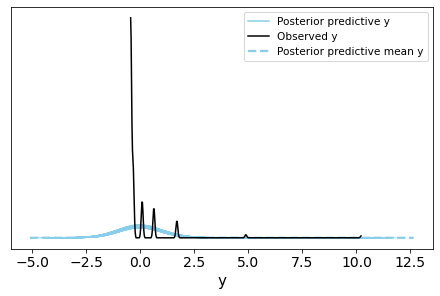

In [99]:
data = az.from_pymc3(trace=complex_h_trace, posterior_predictive=posterior_predictive_linear)
# data = az.from_pymc3(trace=trace_linear, posterior_predictive=posterior_predictive_linear)
az.plot_ppc(data,color= '#87ceeb');

In [107]:
# Context for the model
# Normal LR
with pm.Model() as st_normal_lr_model:
    
    # The prior for the model parameters will be a normal distribution
    family = pm.glm.families.StudentT()
    
    # Making the model only requires specifying the formula and the data
    pm.GLM.from_formula(formula, X_train_math, family = family)
    
    # Perform Markov Chain Monte Carlo sampling
    # normal_trace = pm.sample(init="adapt_diag",draws=NDRAWS, tune = 1000)
    st_normal_lr_trace = pm.sample(init="adapt_diag",draws=NDRAWS, tune = 1000)
    st_posterior_predictive_linear = pm.sample_posterior_predictive(normal_lr_trace,1000)


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lam, retail_price, price, merch_pop_proc, merchant_rating_count, rating, Intercept]
Sampling chain 1, 0 divergences: 100%|██████████| 6000/6000 [00:37<00:00, 159.47it/s]
/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:21<00:00, 46.80it/s]


arviz.data.io_pymc3 - WARNING - posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


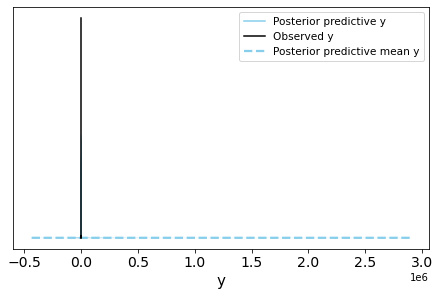

In [108]:
data = az.from_pymc3(trace=st_normal_lr_trace, posterior_predictive=st_posterior_predictive_linear)
# data = az.from_pymc3(trace=trace_linear, posterior_predictive=posterior_predictive_linear)
az.plot_ppc(data,color= '#87ceeb');

In [25]:
with pm.Model() as simple_h:
    grp_mean = pm.Normal("grp_mean", mu=0, sigma=10)
    grp_prec = pm.Gamma("grp_prec", alpha=1, beta=0.1, testval=1.0)
    slope = pm.StudentT.dist(mu=grp_mean, lam=grp_prec, nu=1)
    intercept = pm.Normal.dist(mu=-df1['rating'].mean(), sigma=df1['rating'].std())
    pm.GLM.from_formula(
        formula,
        X_train_math,
        priors={"Intercept": intercept, "Regressor": slope},
    )
    simple_h_trace = pm.sample(draws=NDRAWS, tune = 1000,init = None, step = pm.Metropolis())

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [sd]
>Metropolis: [retail_price]
>Metropolis: [price]
>Metropolis: [merch_pop_proc]
>Metropolis: [merchant_rating_count]
>Metropolis: [rating]
>Metropolis: [Intercept]
>Metropolis: [grp_prec]
>Metropolis: [grp_mean]
Sampling chain 1, 0 divergences: 100%|██████████| 6000/6000 [00:14<00:00, 407.08it/s]
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [26]:
with pm.Model() as basline_h:
    #X_train_math['rating].mean(),X_train_math['rating].std()
    rating_mean = pm.Normal("rating_mean", mu=df1['rating'].mean(), sigma=df1['rating'].std())
    rating_sd = pm.Uniform("rating_sd", df1['rating'].min(), df1['rating'].max())
    
    mr_mean  = pm.Normal("mr_mean", mu=df1['merchant_rating_count'].mean(), sigma=df1['merchant_rating_count'].std())
    mr_sd = pm.Uniform("mr_sd",df1['merchant_rating_count'].min(), df1['merchant_rating_count'].max())

    mrp_mean = pm.Normal("mrp_mean", mu=df1['merch_pop_proc'].mean(), sigma=df1['merch_pop_proc'].std())
    mrp_sd = pm.Uniform("mrp_sd", df1['merch_pop_proc'].min(),df1['merch_pop_proc'].max())

    # price_mean  = pm.Normal("price_mean", mu=df1['price'].mean(), sigma=df1['price'].std())
    # price_sd = pm.Uniform("price_sd", df1['price'].min(),df1['price'].max())

    # re_price_mean = pm.Normal("re_price_mean", mu=df1['retail_price'].mean(), sigma=df1['retail_price'].std())
    # re_price_sd = pm.Uniform("re_price_sd", df1['retail_price'].min(), df1['retail_price'].max())
    
    # Define priors for intercept and regression coefficients.
    priors = {
        "Intercept": pm.Normal.dist(mu=df1['rating'].mean(), sigma=df1['rating'].std()),
        "rating ": pm.Normal.dist(mu=rating_mean, sigma=rating_sd),
        "merchant_rating_count ": pm.Normal.dist(mu=mr_mean, sigma=mr_sd),
        "merch_pop_proc": pm.Normal.dist(mu=mrp_mean, sigma=mrp_sd)
        # ,"price": pm.Normal.dist(mu=price_mean, sigma=price_sd),
        # "retail_price": pm.Normal.dist(mu=re_price_mean, sigma=re_price_sd)
    }
    pm.GLM.from_formula('y ~ rating + merchant_rating_count + merch_pop_proc', X_train_math, priors=priors)
    basline_h_trace = pm.sample(draws=NDRAWS, tune = 1000,init = None, step = pm.Metropolis())

    # normal_trace = pm.sample(init="adapt_diag",draws=NDRAWS, tune = 1000)


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [sd]
>Metropolis: [merch_pop_proc]
>Metropolis: [merchant_rating_count]
>Metropolis: [rating]
>Metropolis: [Intercept]
>Metropolis: [mrp_sd]
>Metropolis: [mrp_mean]
>Metropolis: [mr_sd]
>Metropolis: [mr_mean]
>Metropolis: [rating_sd]
>Metropolis: [rating_mean]
Sampling chain 1, 0 divergences: 100%|██████████| 6000/6000 [00:15<00:00, 375.09it/s]
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [105]:
with pm.Model() as complex_h:
    #X_train_math['rating].mean(),X_train_math['rating].std()
    rating_mean = pm.Normal("rating_mean", mu=df1['rating'].mean(), sigma=df1['rating'].std())
    rating_sd = pm.Uniform("rating_sd", df1['rating'].min(), df1['rating'].max())
    
    mr_mean  = pm.Normal("mr_mean", mu=df1['merchant_rating_count'].mean(), sigma=df1['merchant_rating_count'].std())
    mr_sd = pm.Uniform("mr_sd",df1['merchant_rating_count'].min(), df1['merchant_rating_count'].max())

    mrp_mean = pm.Normal("mrp_mean", mu=df1['merch_pop_proc'].mean(), sigma=df1['merch_pop_proc'].std())
    mrp_sd = pm.Uniform("mrp_sd", df1['merch_pop_proc'].min(),df1['merch_pop_proc'].max())

    price_mean  = pm.Normal("price_mean", mu=df1['price'].mean(), sigma=df1['price'].std())
    price_sd = pm.Uniform("price_sd", df1['price'].min(),df1['price'].max())

    re_price_mean = pm.Normal("re_price_mean", mu=df1['retail_price'].mean(), sigma=df1['retail_price'].std())
    re_price_sd = pm.Uniform("re_price_sd", df1['retail_price'].min(), df1['retail_price'].max())
    
    # Define priors for intercept and regression coefficients.
    priors = {
        "Intercept": pm.Normal.dist(mu=df1['rating'].mean(), sigma=df1['rating'].std()),
        "rating ": pm.Normal.dist(mu=rating_mean, sigma=rating_sd),
        "merchant_rating_count ": pm.Normal.dist(mu=mr_mean, sigma=mr_sd),
        "merch_pop_proc": pm.Normal.dist(mu=mrp_mean, sigma=mrp_sd),
        "price": pm.Normal.dist(mu=price_mean, sigma=price_sd),
        "retail_price": pm.Normal.dist(mu=re_price_mean, sigma=re_price_sd)
    }
    pm.GLM.from_formula(formula, X_train_math, priors=priors)
    complex_h_trace = pm.sample(draws=NDRAWS, tune = 1000,init = None, step = pm.Metropolis())
    cposterior_predictive_linear = pm.sample_posterior_predictive(complex_h_trace,1000)

    # normal_trace = pm.sample(init="adapt_diag",draws=NDRAWS, tune = 1000)



Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [sd]
>Metropolis: [retail_price]
>Metropolis: [price]
>Metropolis: [merch_pop_proc]
>Metropolis: [merchant_rating_count]
>Metropolis: [rating]
>Metropolis: [Intercept]
>Metropolis: [re_price_sd]
>Metropolis: [re_price_mean]
>Metropolis: [price_sd]
>Metropolis: [price_mean]
>Metropolis: [mrp_sd]
>Metropolis: [mrp_mean]
>Metropolis: [mr_sd]
>Metropolis: [mr_mean]
>Metropolis: [rating_sd]
>Metropolis: [rating_mean]
Sampling chain 1, 0 divergences: 100%|██████████| 6000/6000 [00:35<00:00, 167.84it/s]
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than

arviz.data.io_pymc3 - WARNING - posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


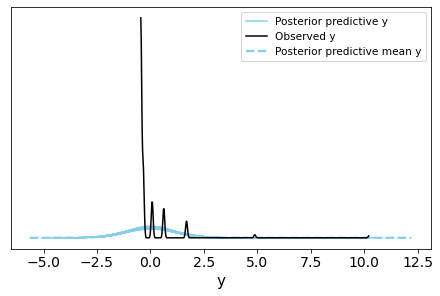

In [106]:
data = az.from_pymc3(trace=complex_h_trace, posterior_predictive=cposterior_predictive_linear)
# data = az.from_pymc3(trace=trace_linear, posterior_predictive=posterior_predictive_linear)
az.plot_ppc(data,color= '#87ceeb');

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb137ea7eb8>,
      dtype=object)

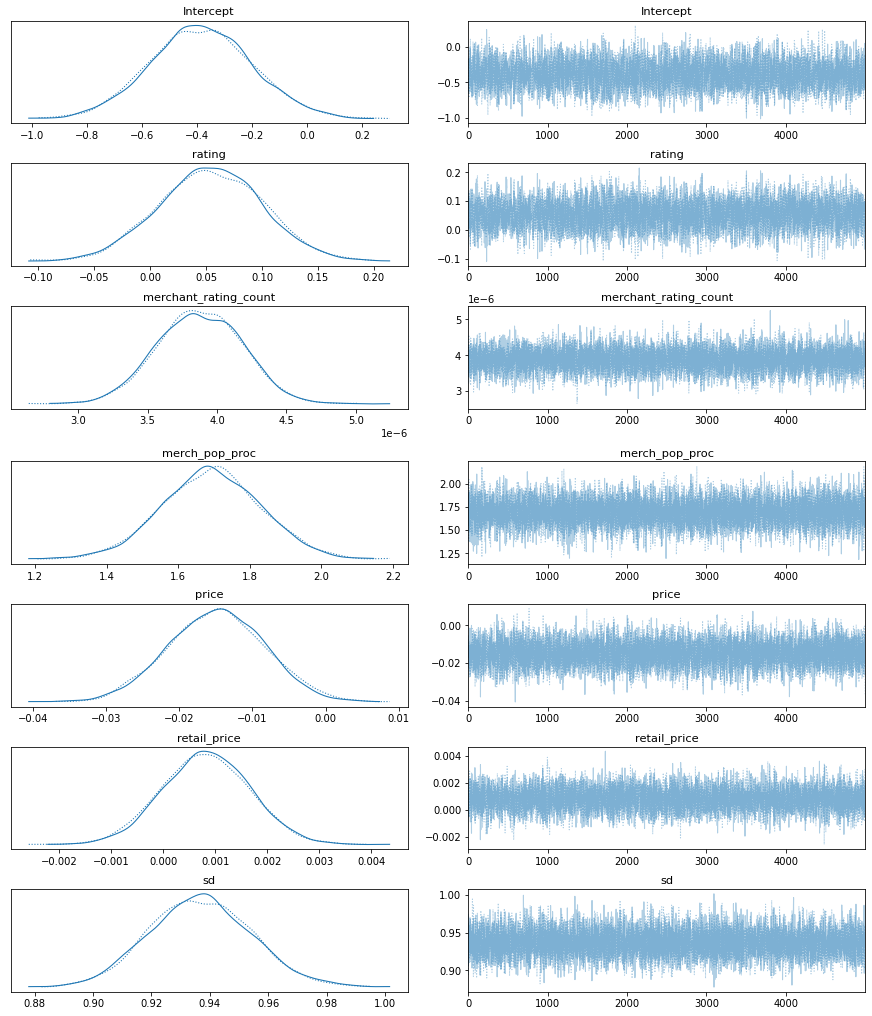

In [44]:
pm.traceplot(normal_lr_trace)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb13966e9e8>,
      dtype=object)

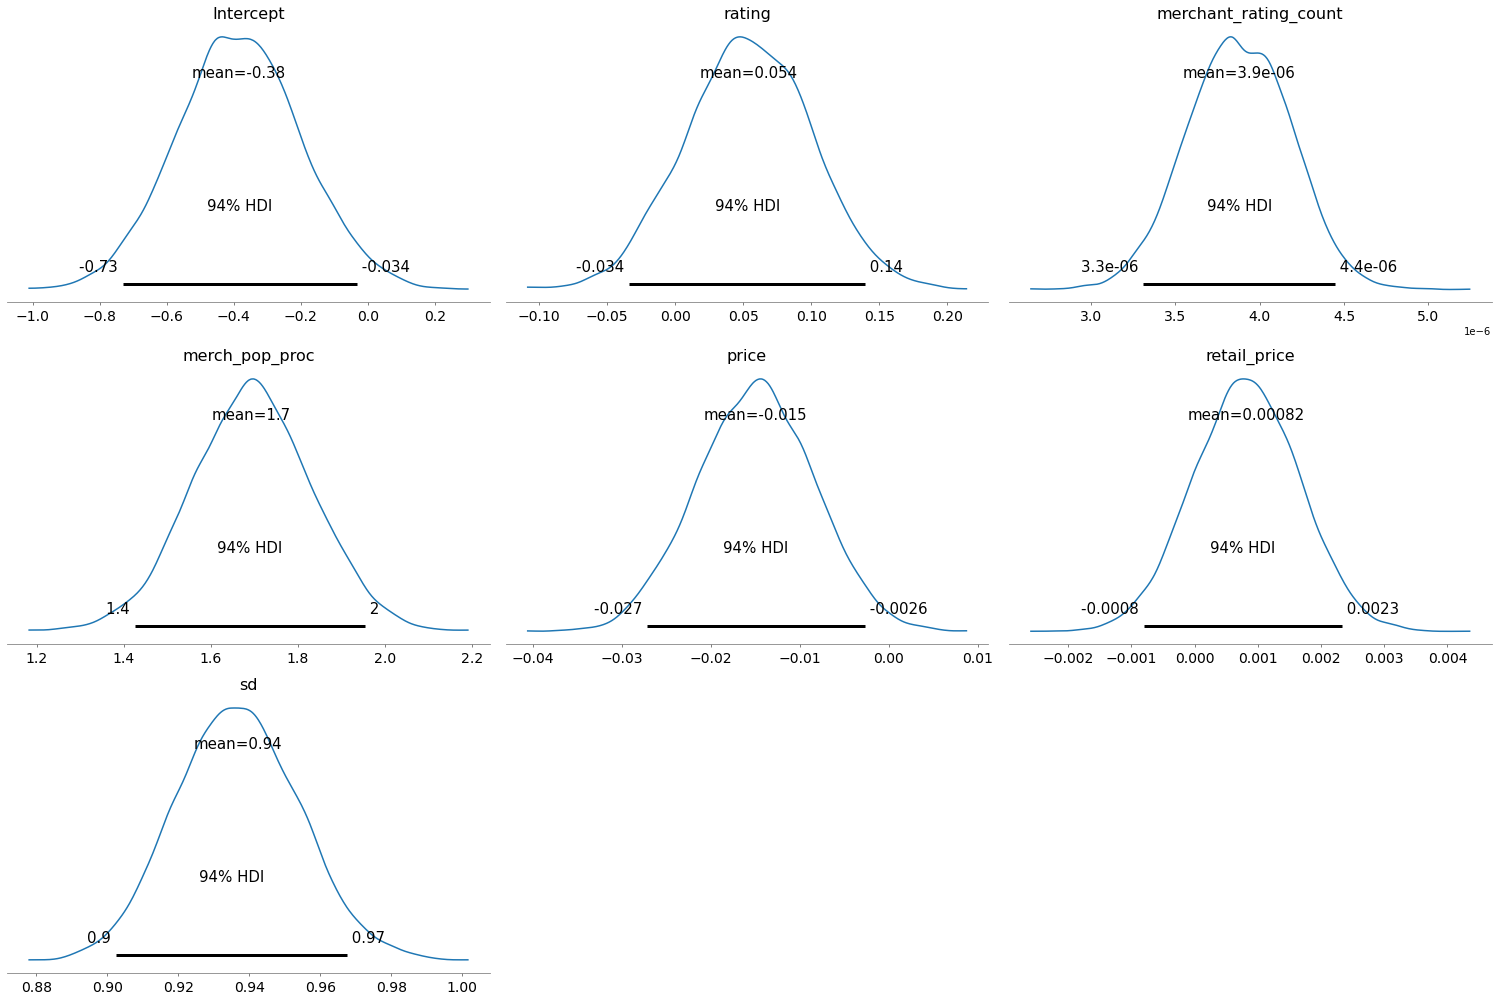

In [47]:
import arviz as az
az.plot_posterior(normal_lr_trace)

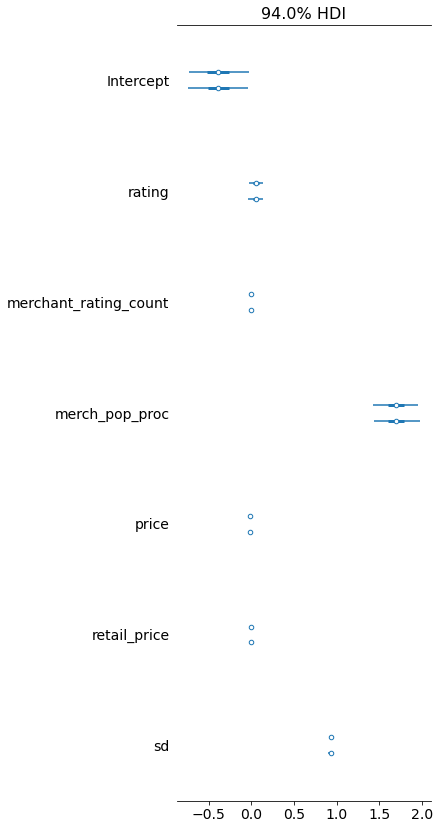

In [73]:
axes = az.plot_forest(normal_lr_trace)
# X_train_math.columns

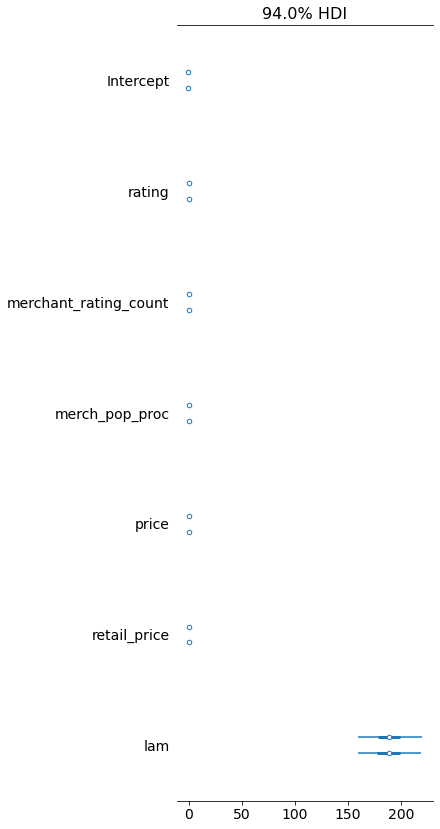

In [74]:
axes = az.plot_forest(st_normal_lr_trace)
# X_train_math.columns

/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:01<00:00, 709.45it/s]
arviz.data.io_pymc3 - WARNING - posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


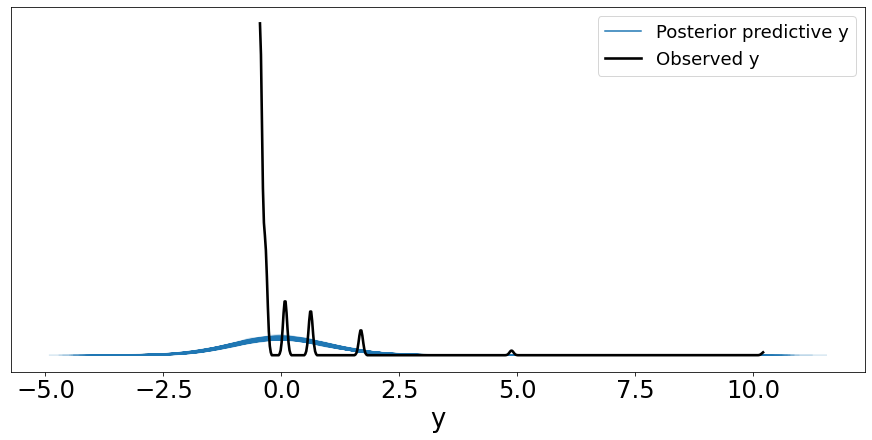

In [81]:
y_pred_g = pm.sample_posterior_predictive(normal_lr_trace,1000, normal_lr_model)
data_ppc = az.from_pymc3(trace=normal_lr_trace, posterior_predictive=y_pred_g)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=False)
# ax[0].legend(fontsize=15)

/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:01<00:00, 640.26it/s]
arviz.data.io_pymc3 - WARNING - posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


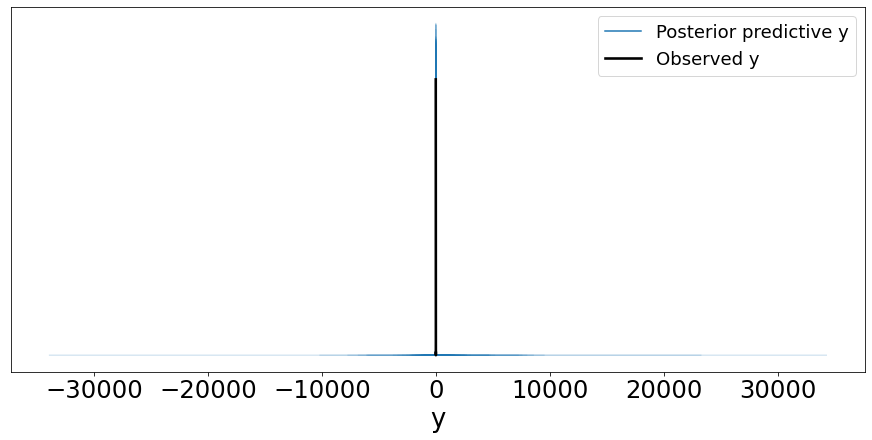

In [82]:
y_pred_g = pm.sample_posterior_predictive(st_normal_lr_trace,1000, st_normal_lr_model)
data_ppc = az.from_pymc3(trace=st_normal_lr_trace, posterior_predictive=y_pred_g)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=False)
# ax[0].legend(fontsize=15)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb164051748>,
      dtype=object)

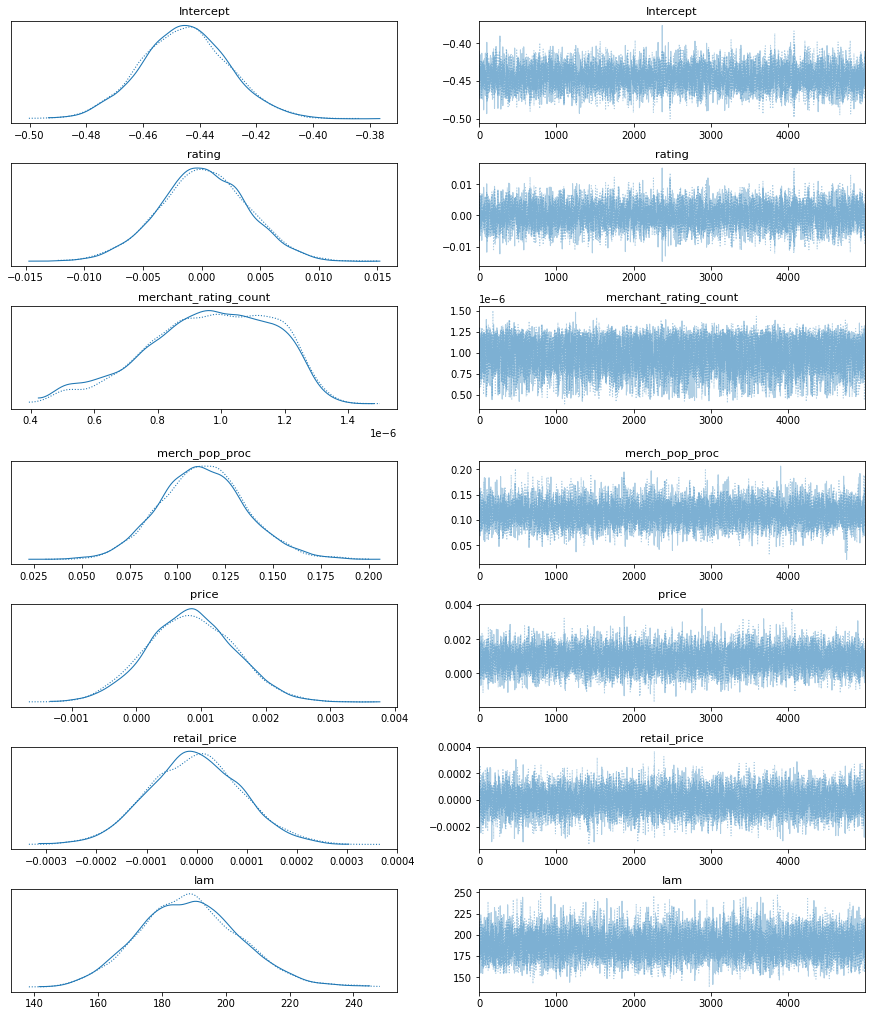

In [48]:
pm.traceplot(st_normal_lr_trace)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb13ae82f28>,
      dtype=object)

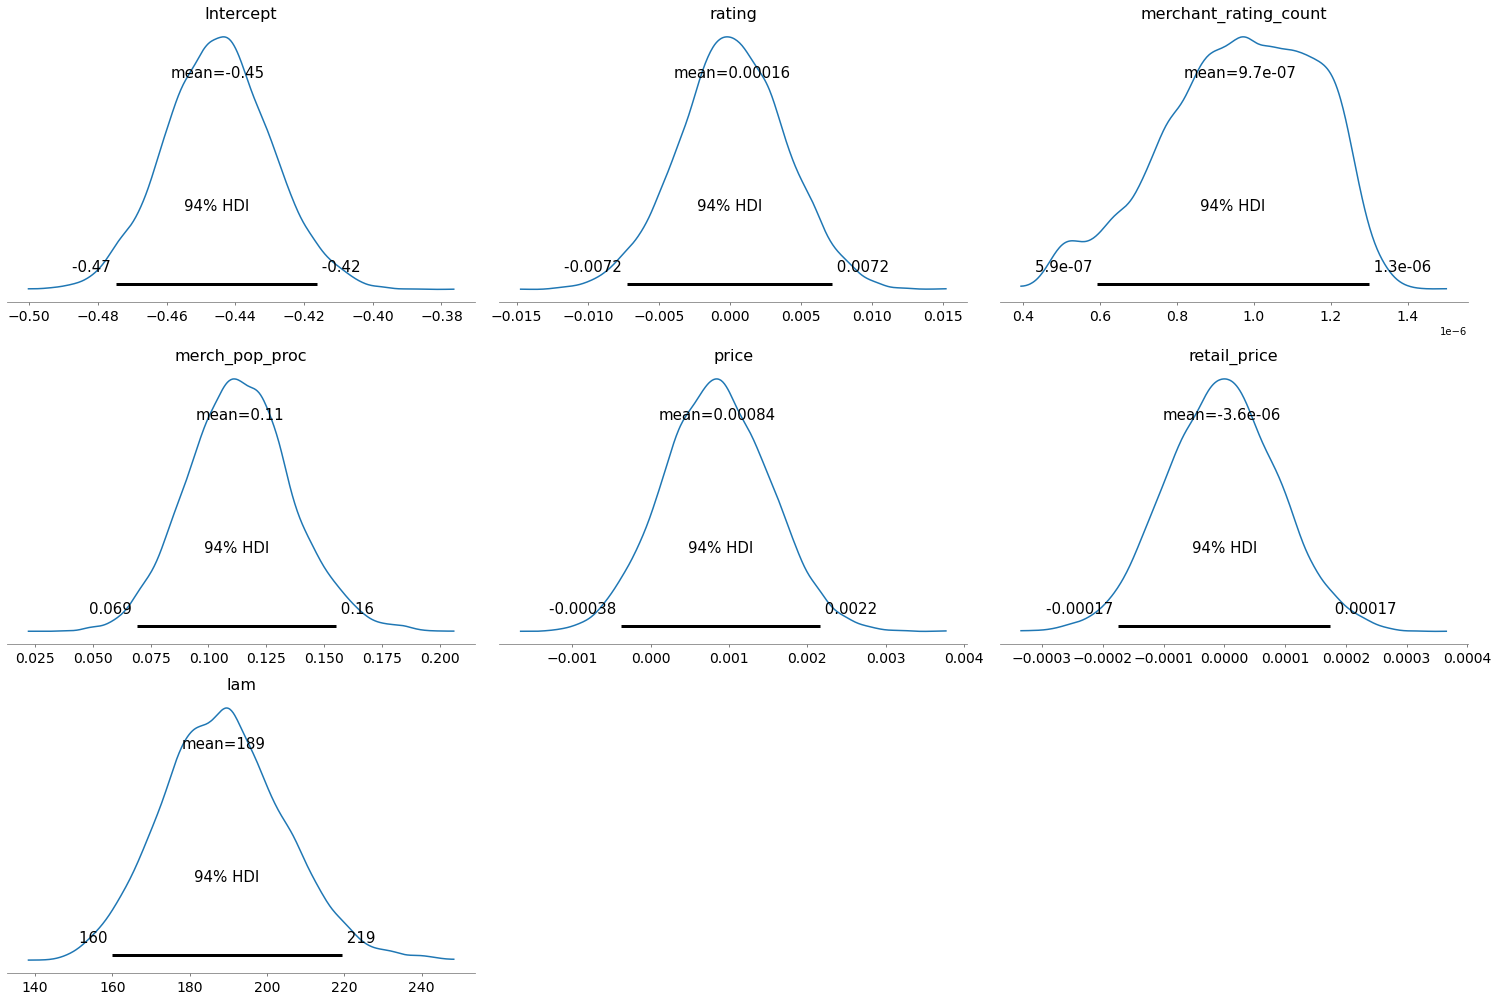

In [50]:
az.plot_posterior(st_normal_lr_trace)

In [30]:
# pm.traceplot(simple_h_trace)

/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:01<00:00, 689.22it/s]
arviz.data.io_pymc3 - WARNING - posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


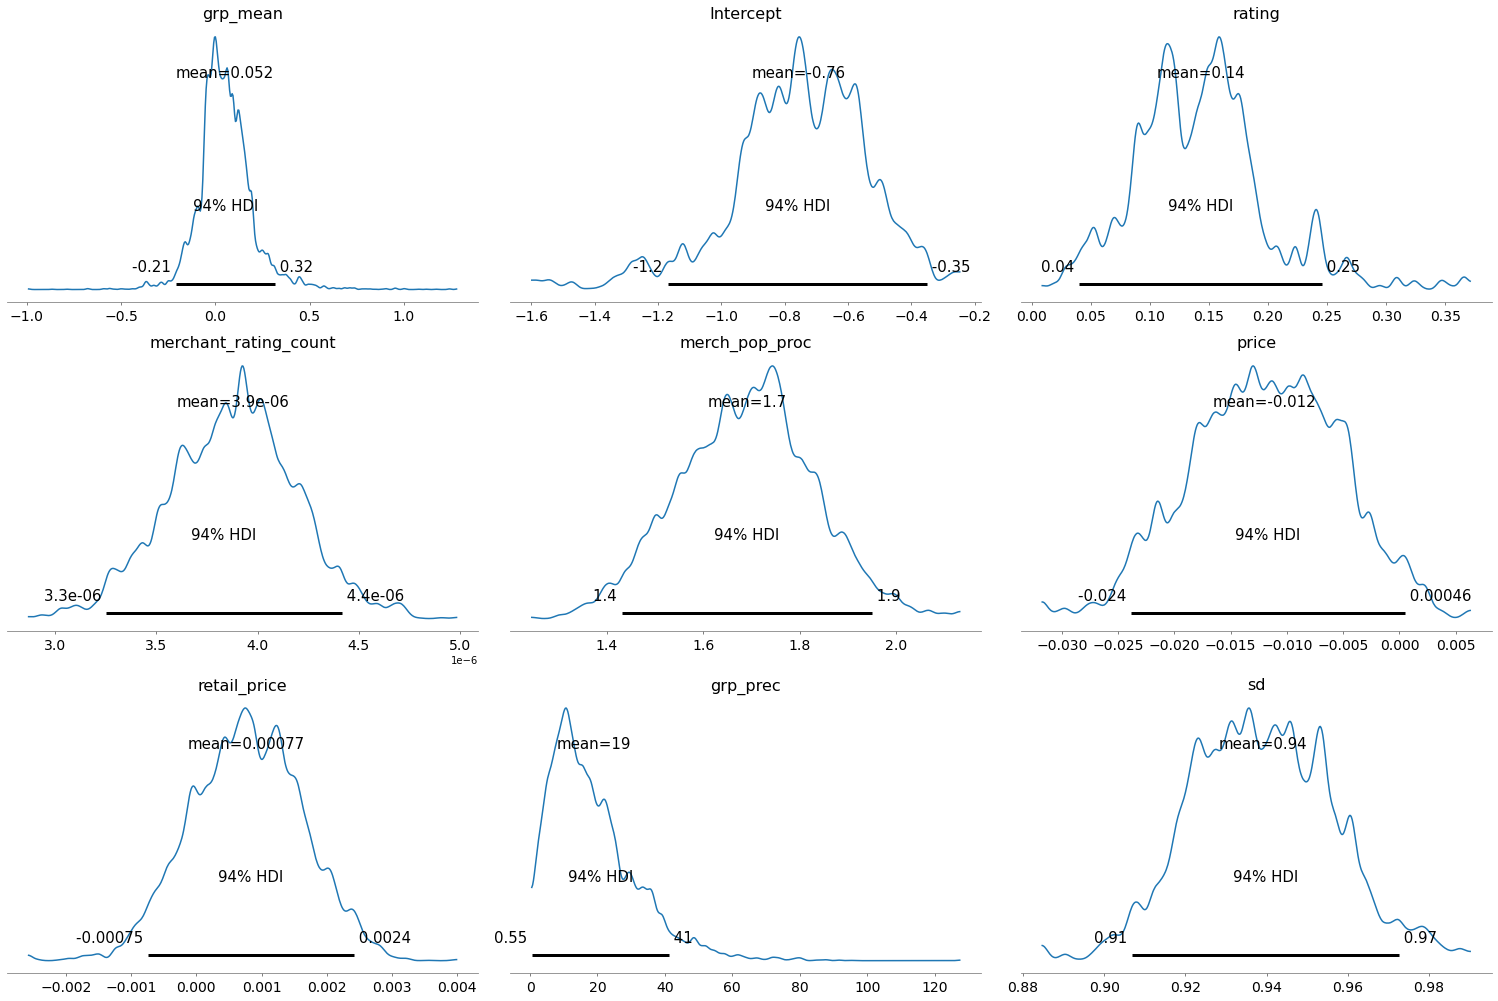

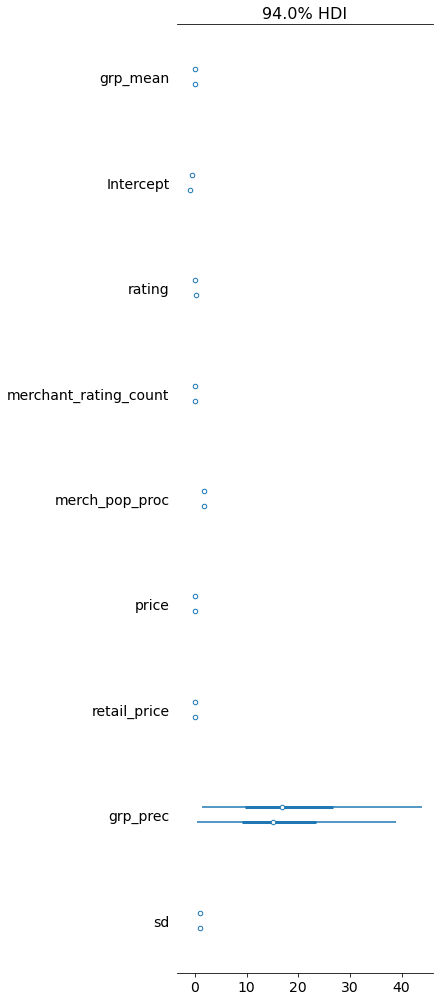

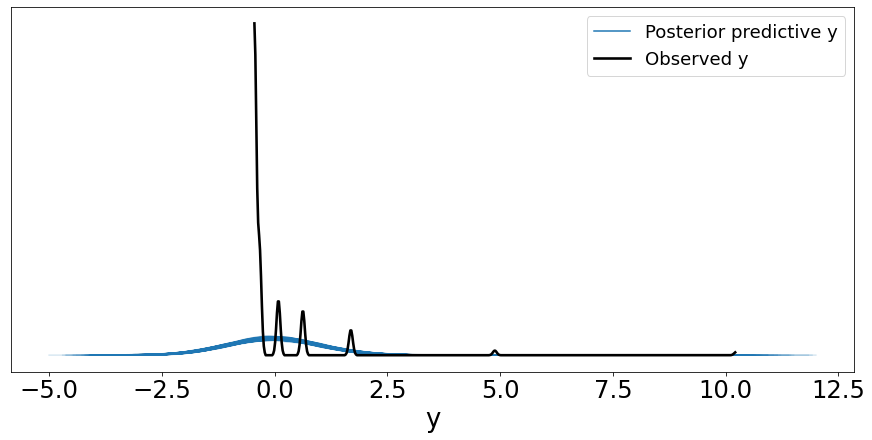

In [83]:
import arviz as az
az.plot_posterior(simple_h_trace)
axes = az.plot_forest(simple_h_trace)
# X_train_math.columns
y_pred_g = pm.sample_posterior_predictive(simple_h_trace,1000, simple_h)
data_ppc = az.from_pymc3(trace=simple_h_trace, posterior_predictive=y_pred_g)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)
# ax[0].legend(fontsize=15)

In [31]:
# pm.traceplot(basline_h_trace)

/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:01<00:00, 720.11it/s]
arviz.data.io_pymc3 - WARNING - posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


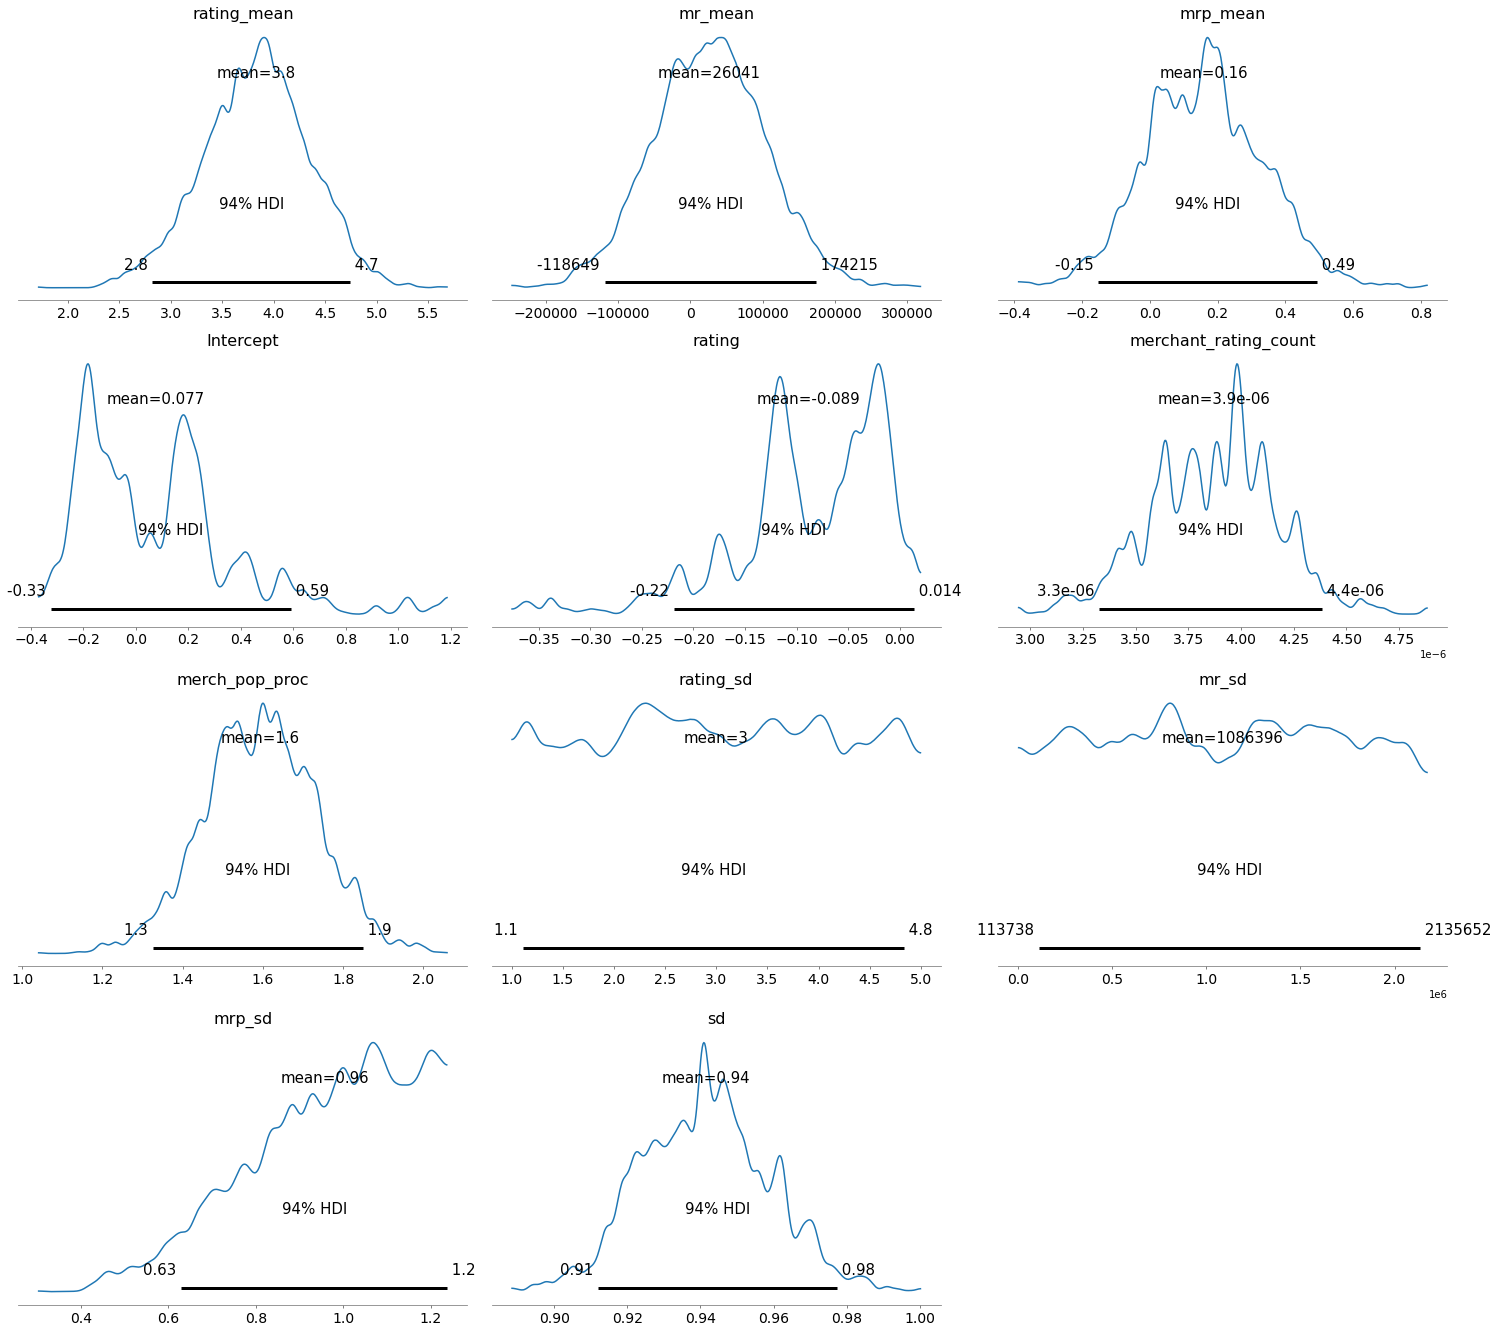

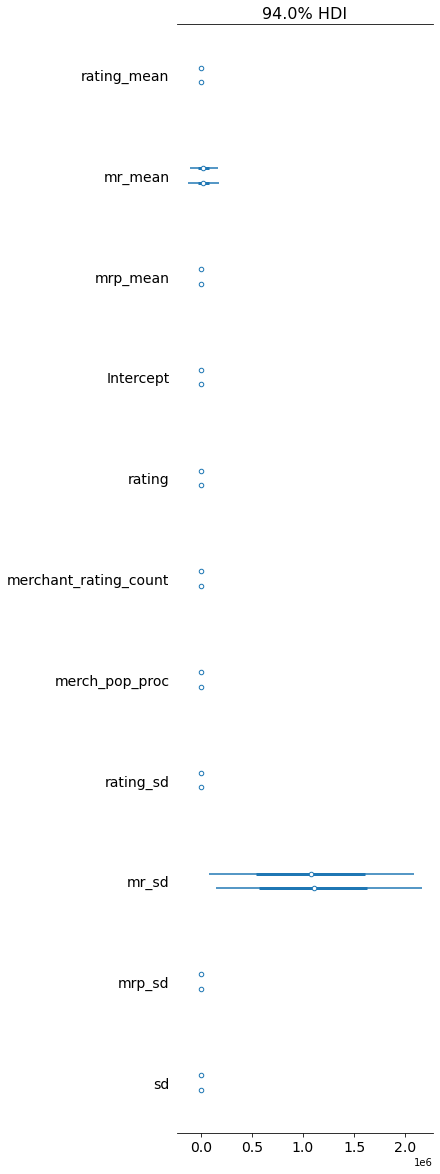

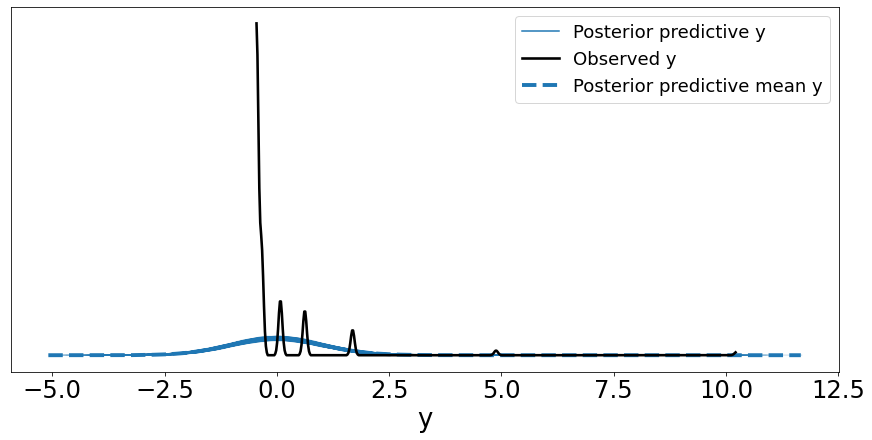

In [84]:
import arviz as az
az.plot_posterior(basline_h_trace)
axes = az.plot_forest(basline_h_trace)
# X_train_math.columns
y_pred_g = pm.sample_posterior_predictive(basline_h_trace,1000, basline_h)
data_ppc = az.from_pymc3(trace=basline_h_trace, posterior_predictive=y_pred_g)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)
# ax[0].legend(fontsize=15)

In [32]:
# pm.traceplot(complex_h_trace)

/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:01<00:00, 702.57it/s]
arviz.data.io_pymc3 - WARNING - posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


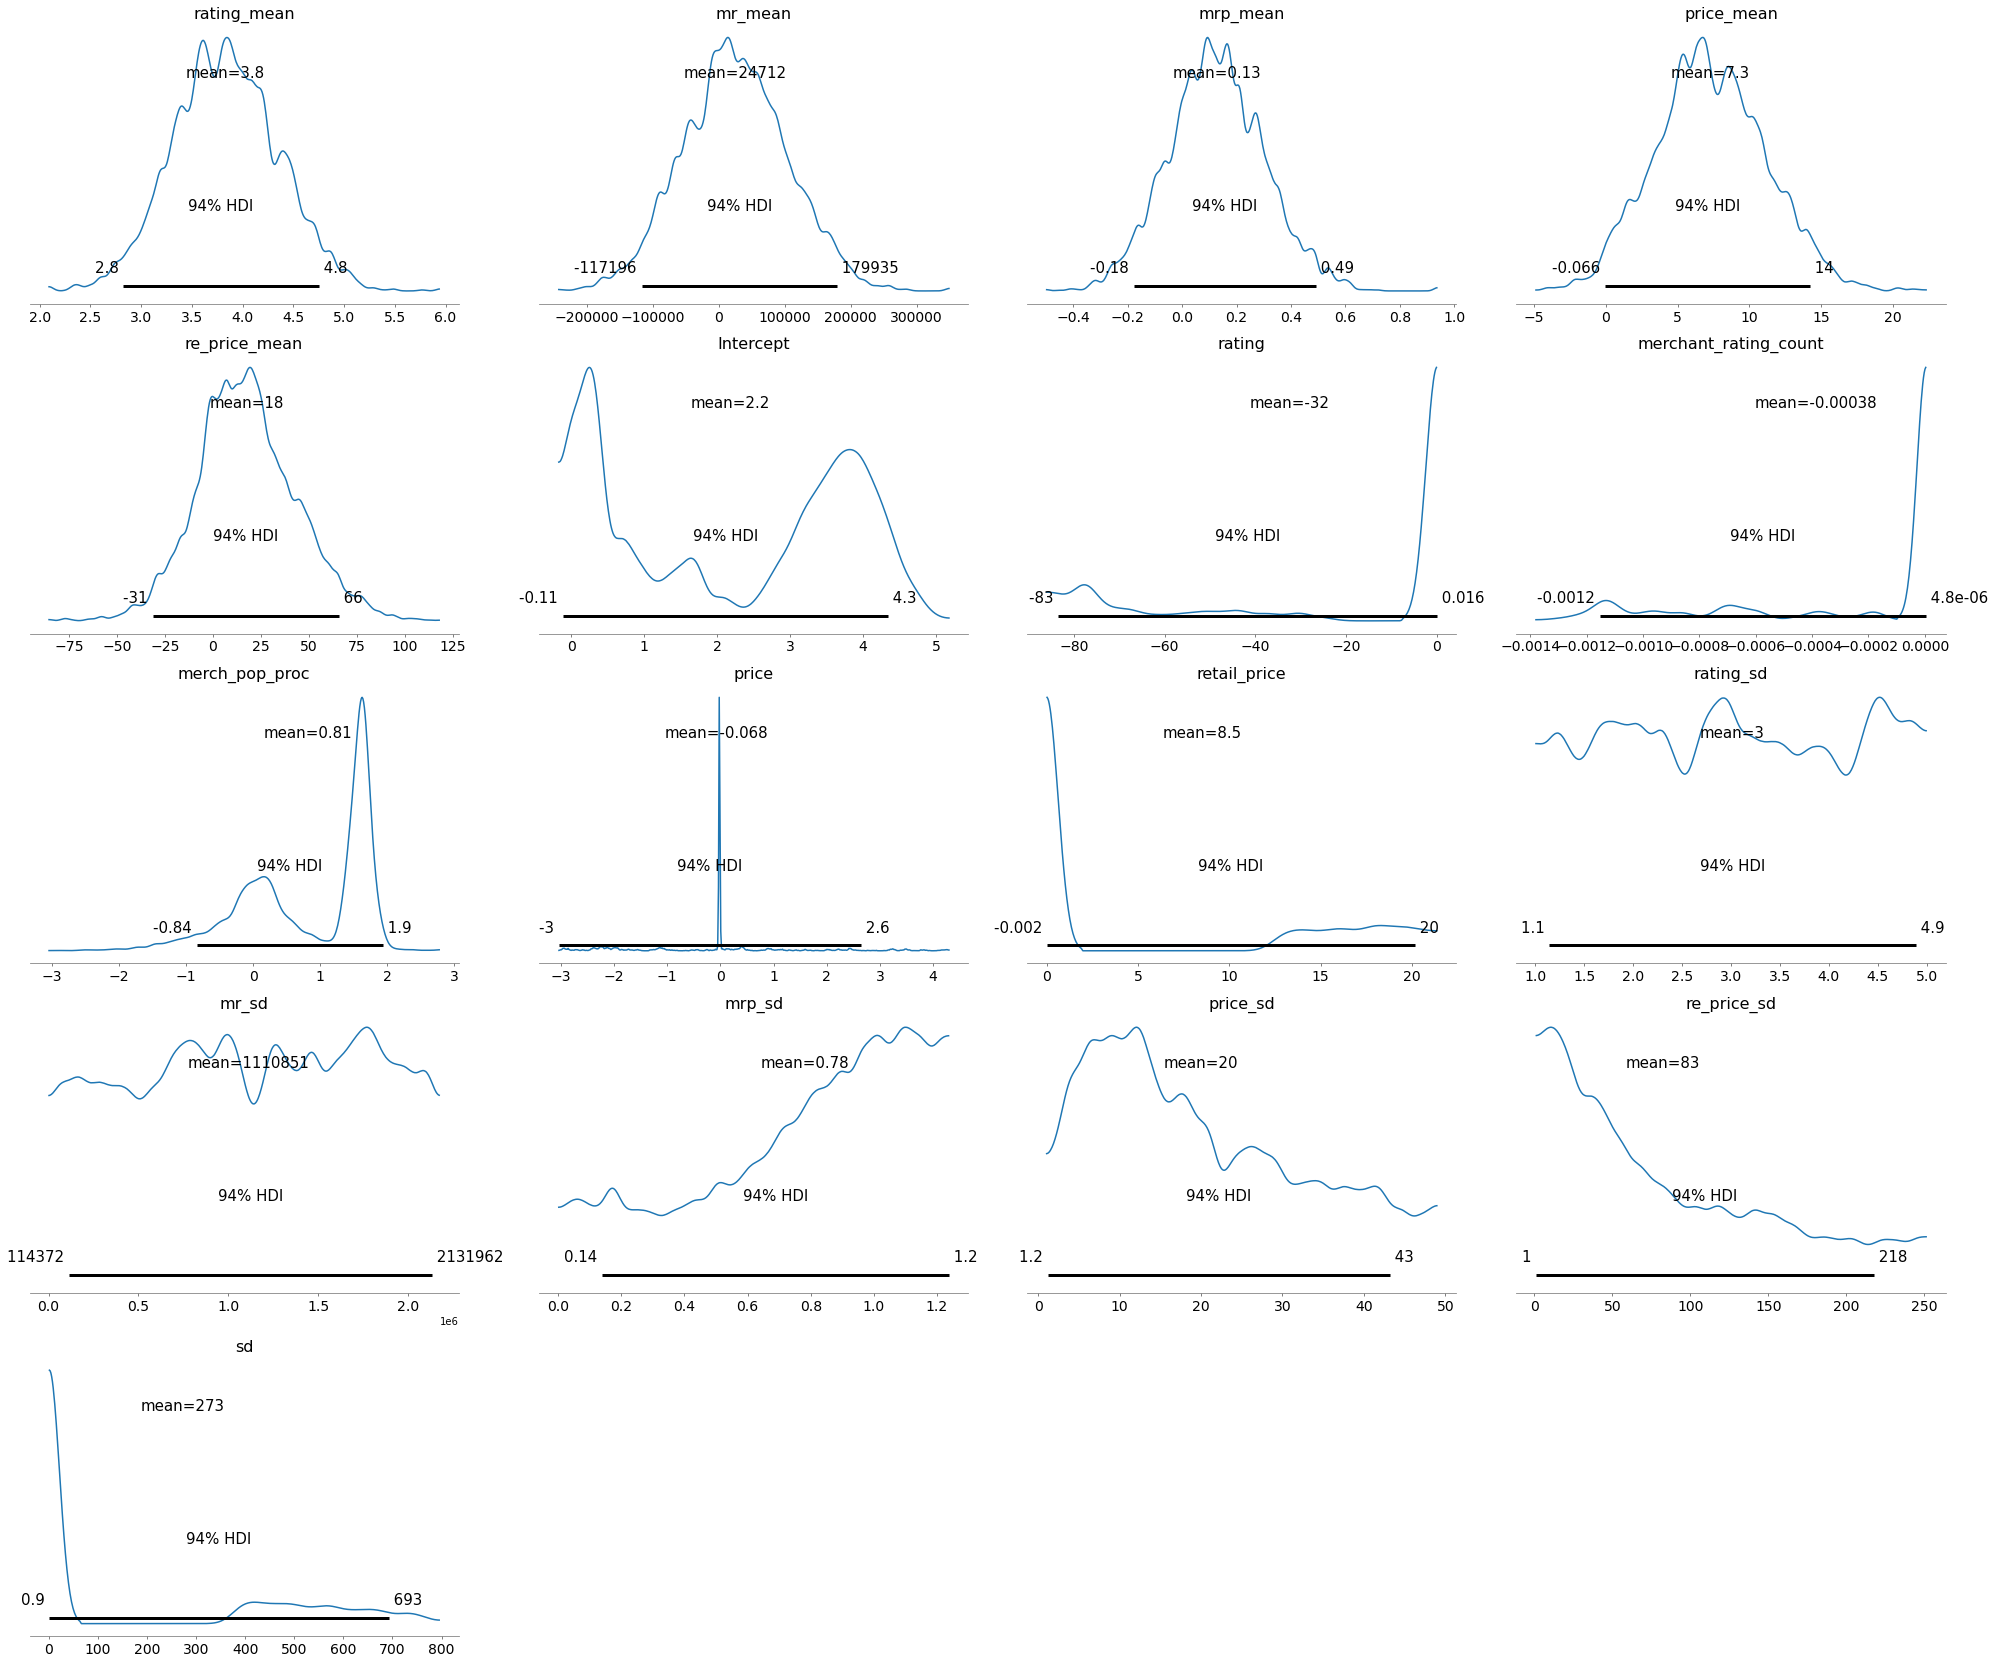

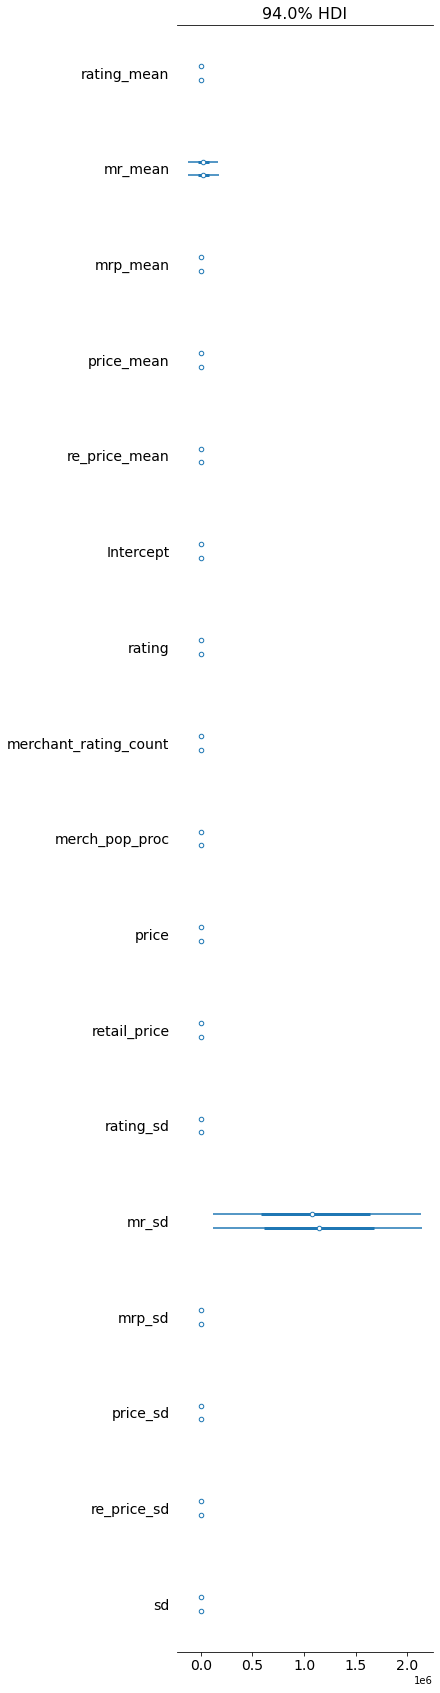

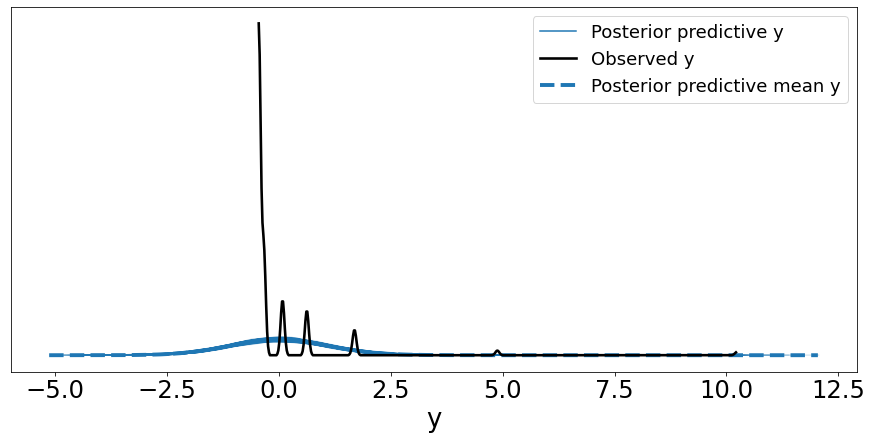

In [104]:
import arviz as az
az.plot_posterior(complex_h_trace)
axes = az.plot_forest(complex_h_trace)
# X_train_math.columns
y_pred_g = pm.sample_posterior_predictive(complex_h_trace,1000, complex_h)
data_ppc = az.from_pymc3(trace=complex_h_trace, posterior_predictive=y_pred_g)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)
# ax[0].legend(fontsize=15)

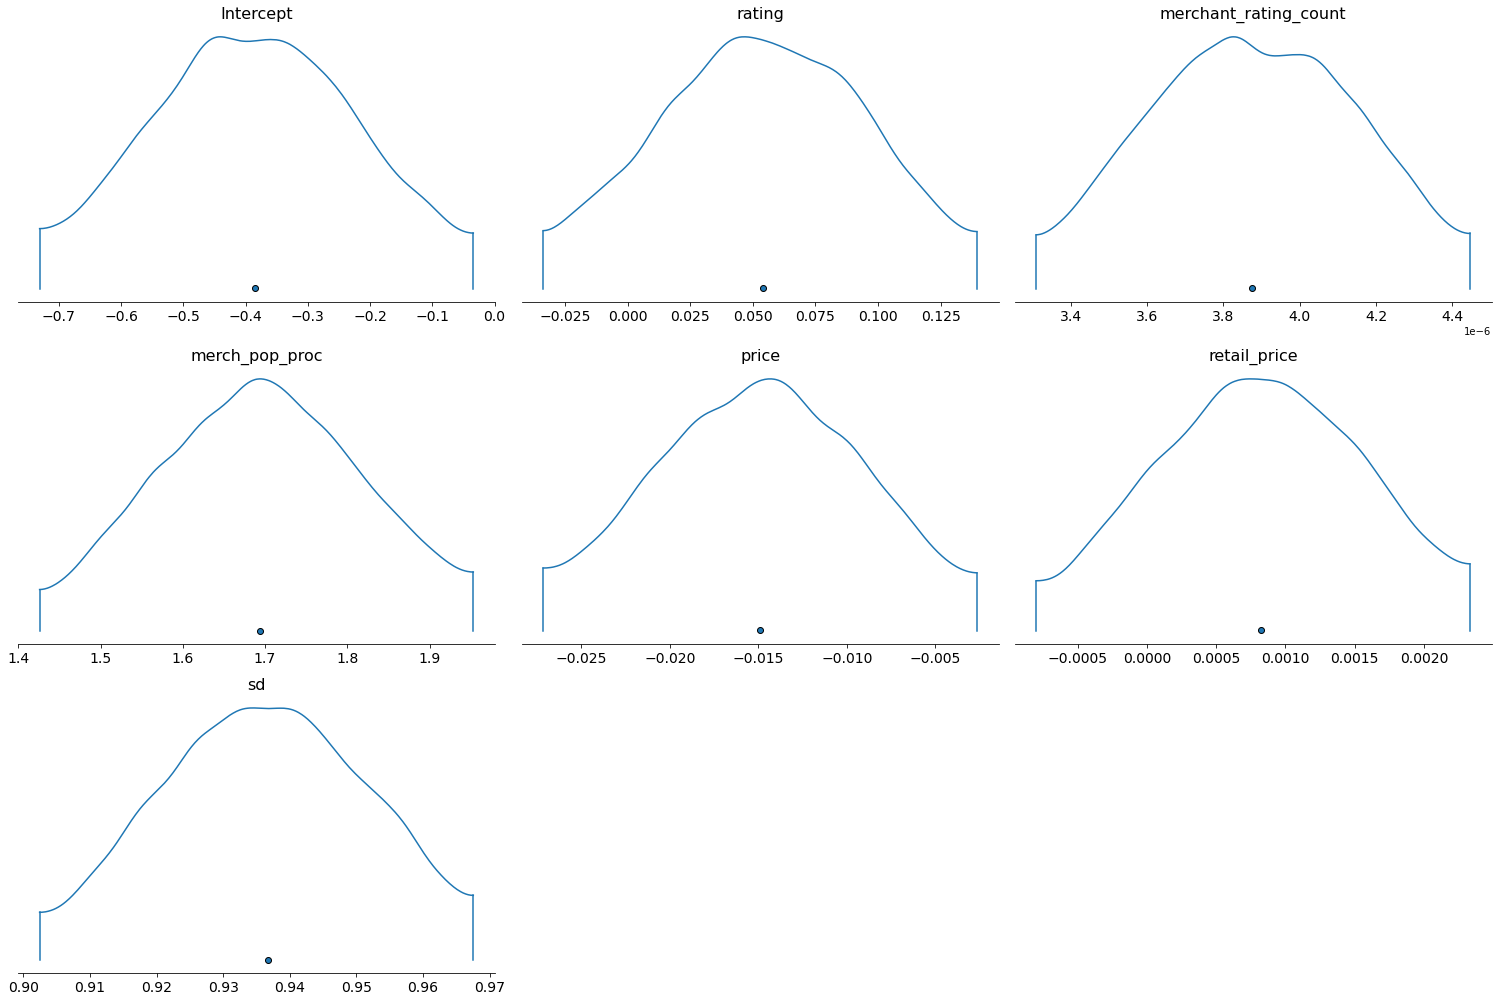

In [33]:
pm.densityplot(normal_lr_trace);


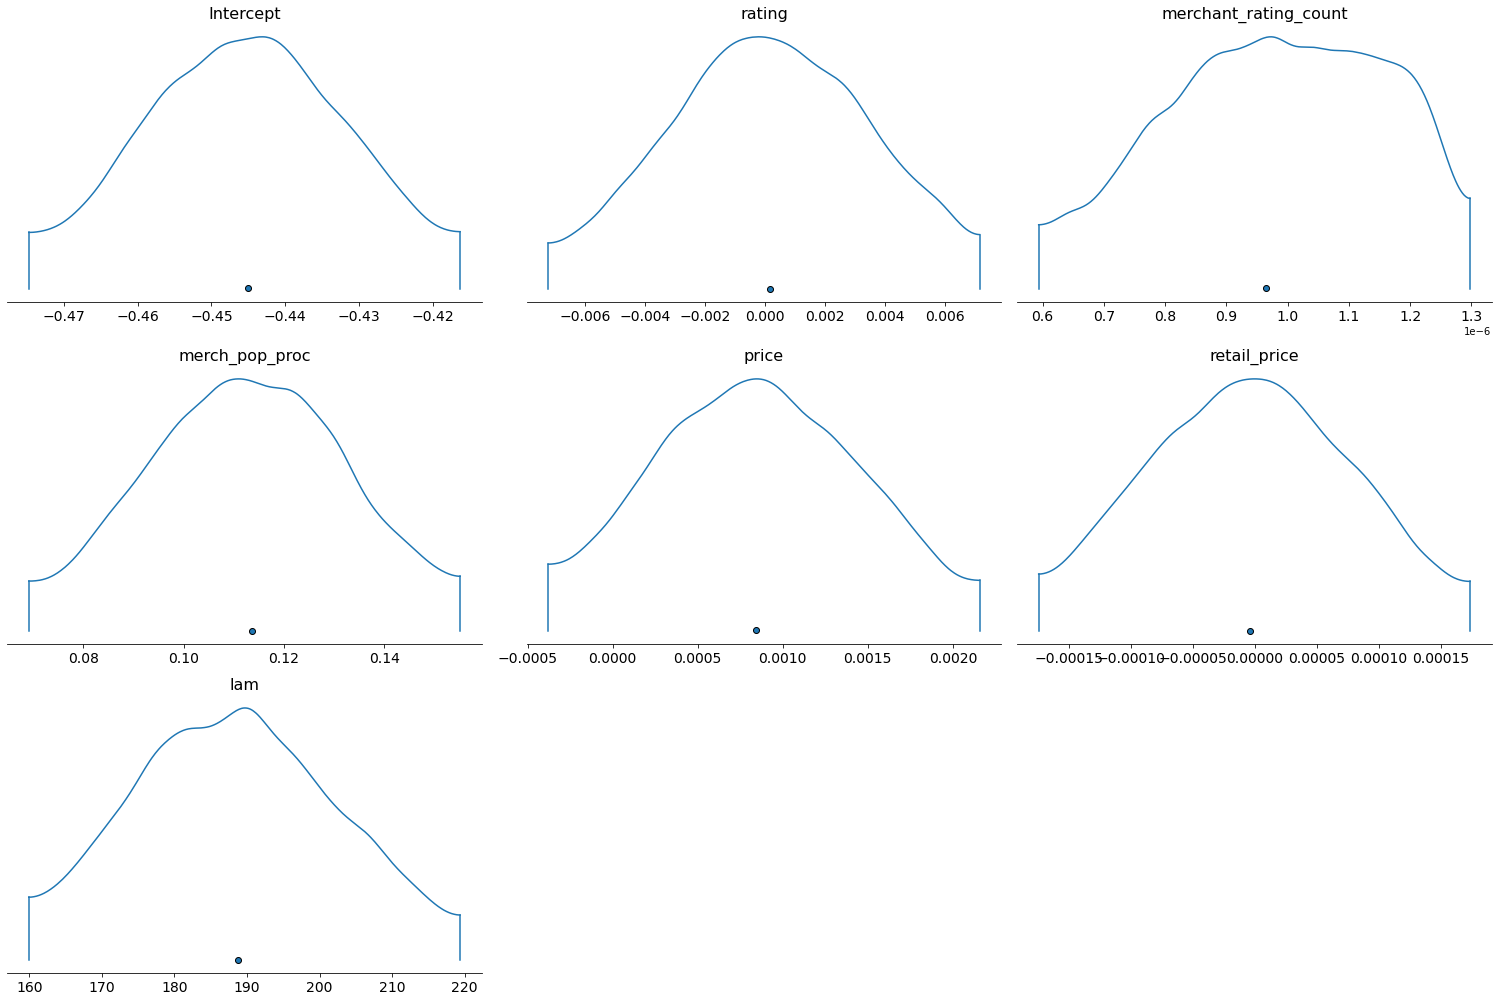

In [34]:
pm.densityplot(st_normal_lr_trace);

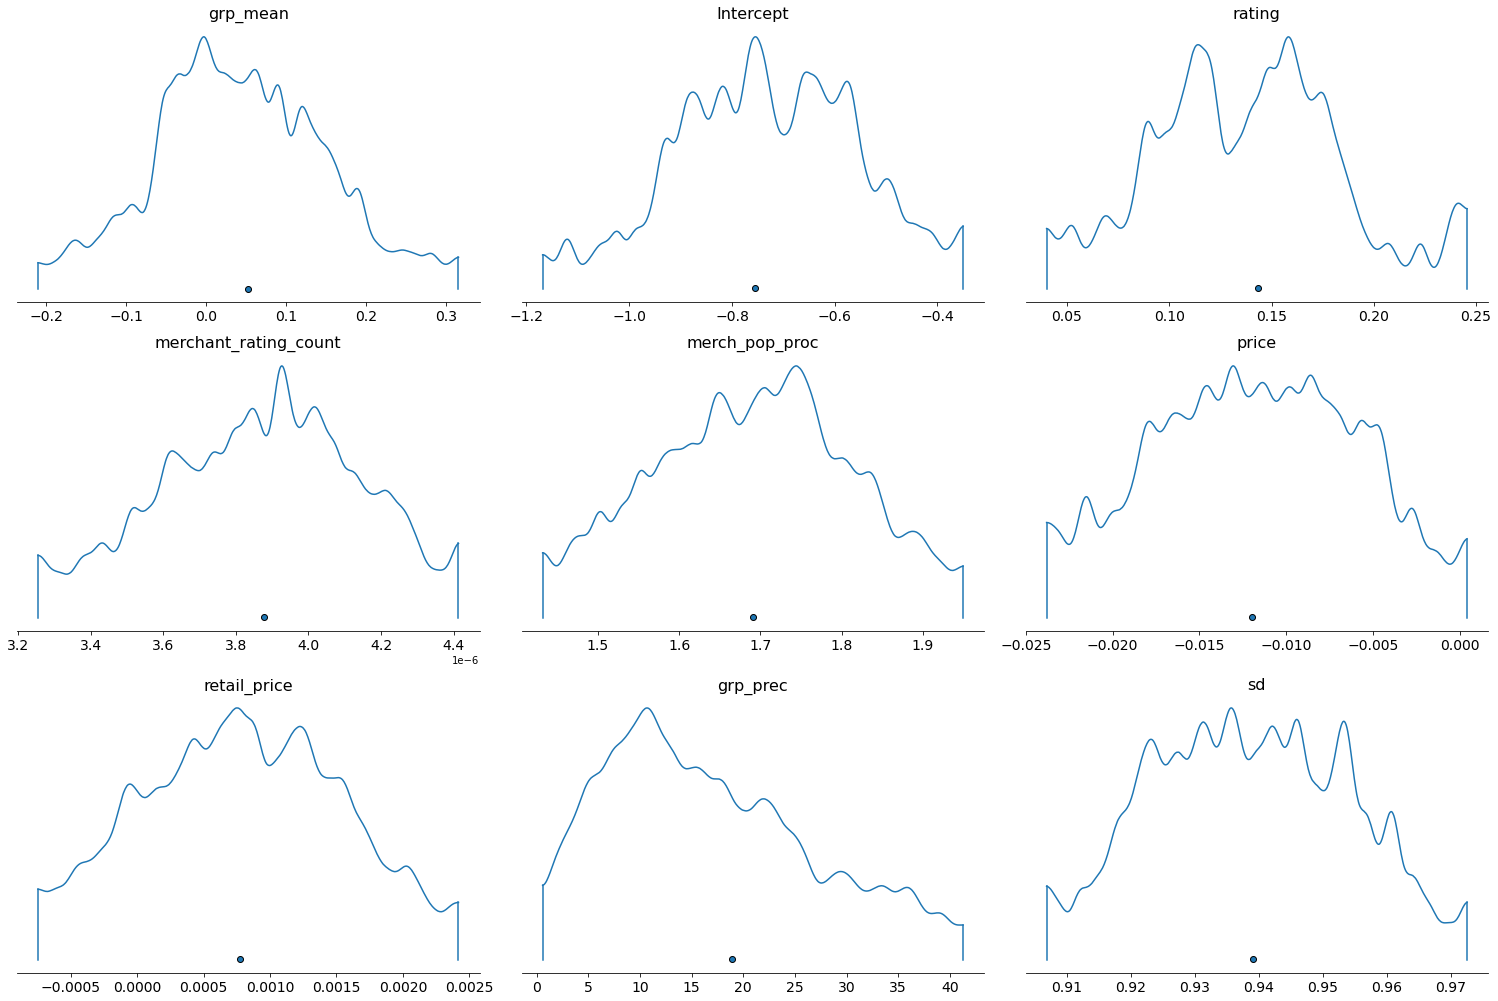

In [35]:
pm.densityplot(simple_h_trace);


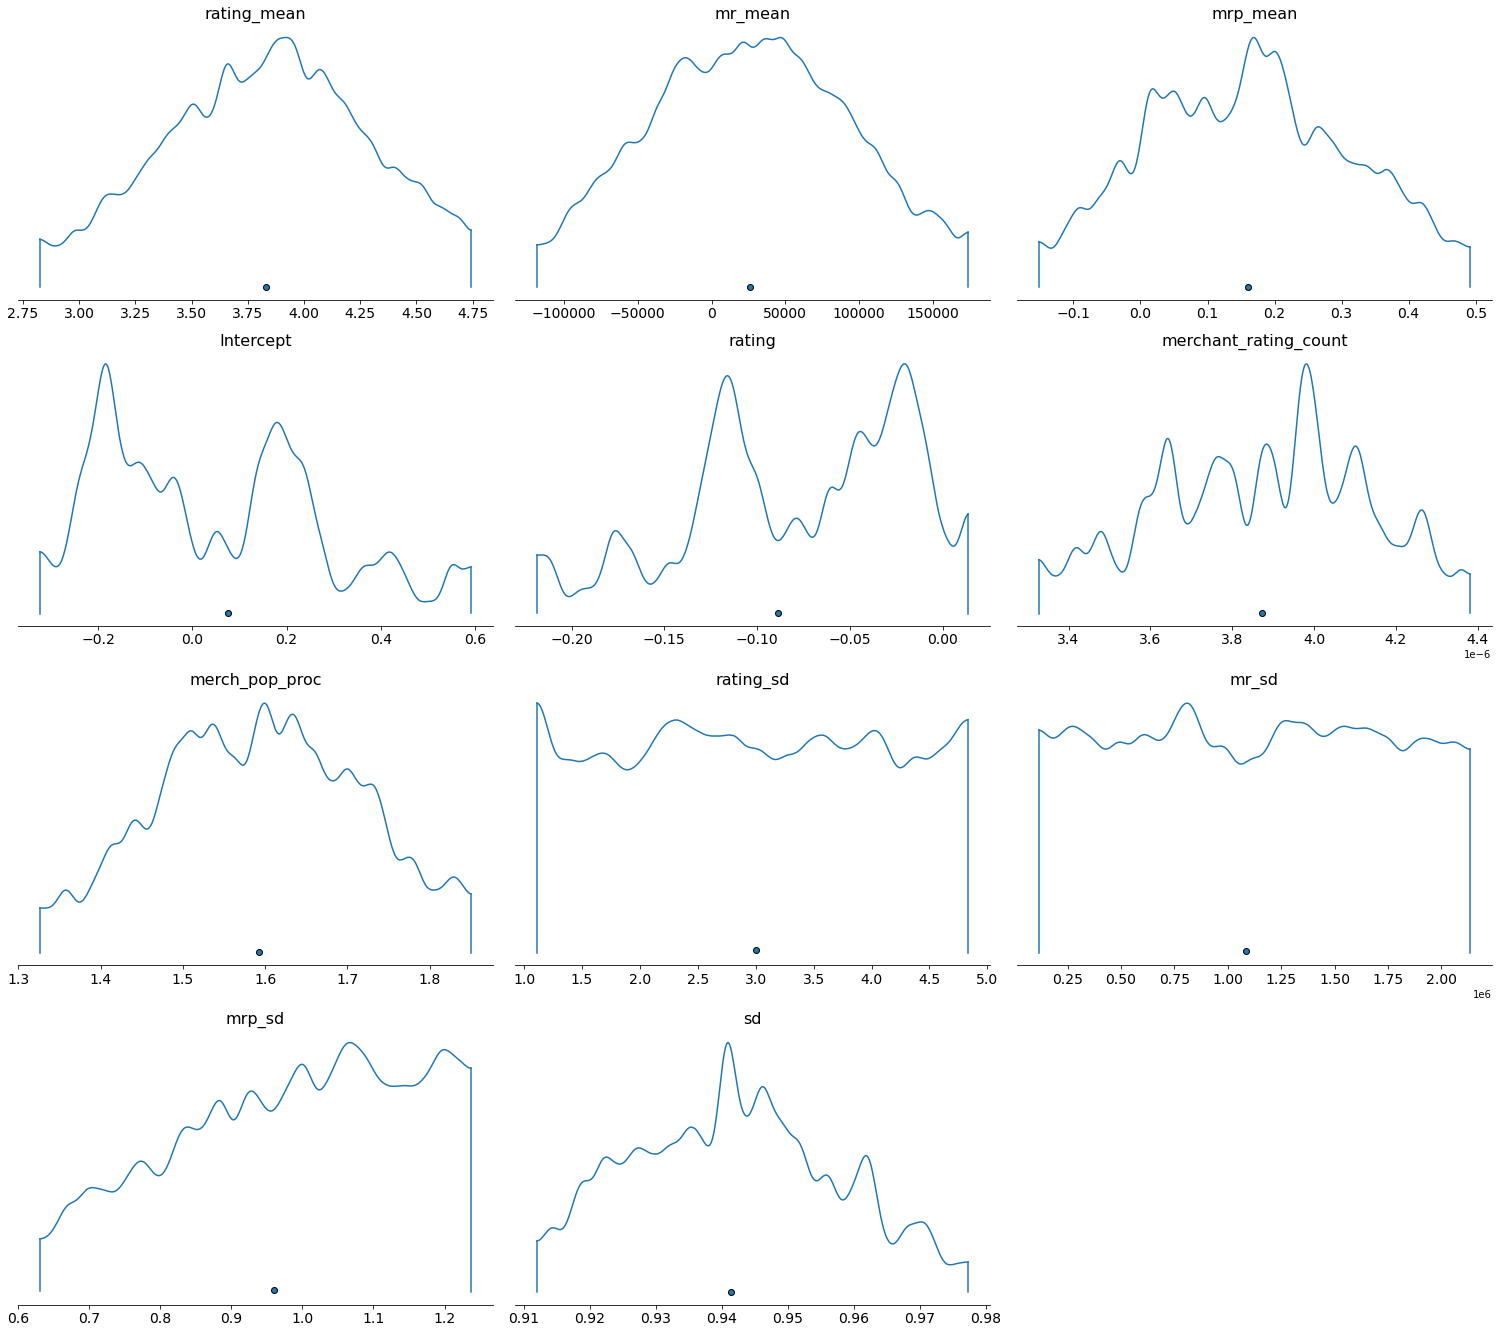

In [36]:
pm.densityplot(basline_h_trace);


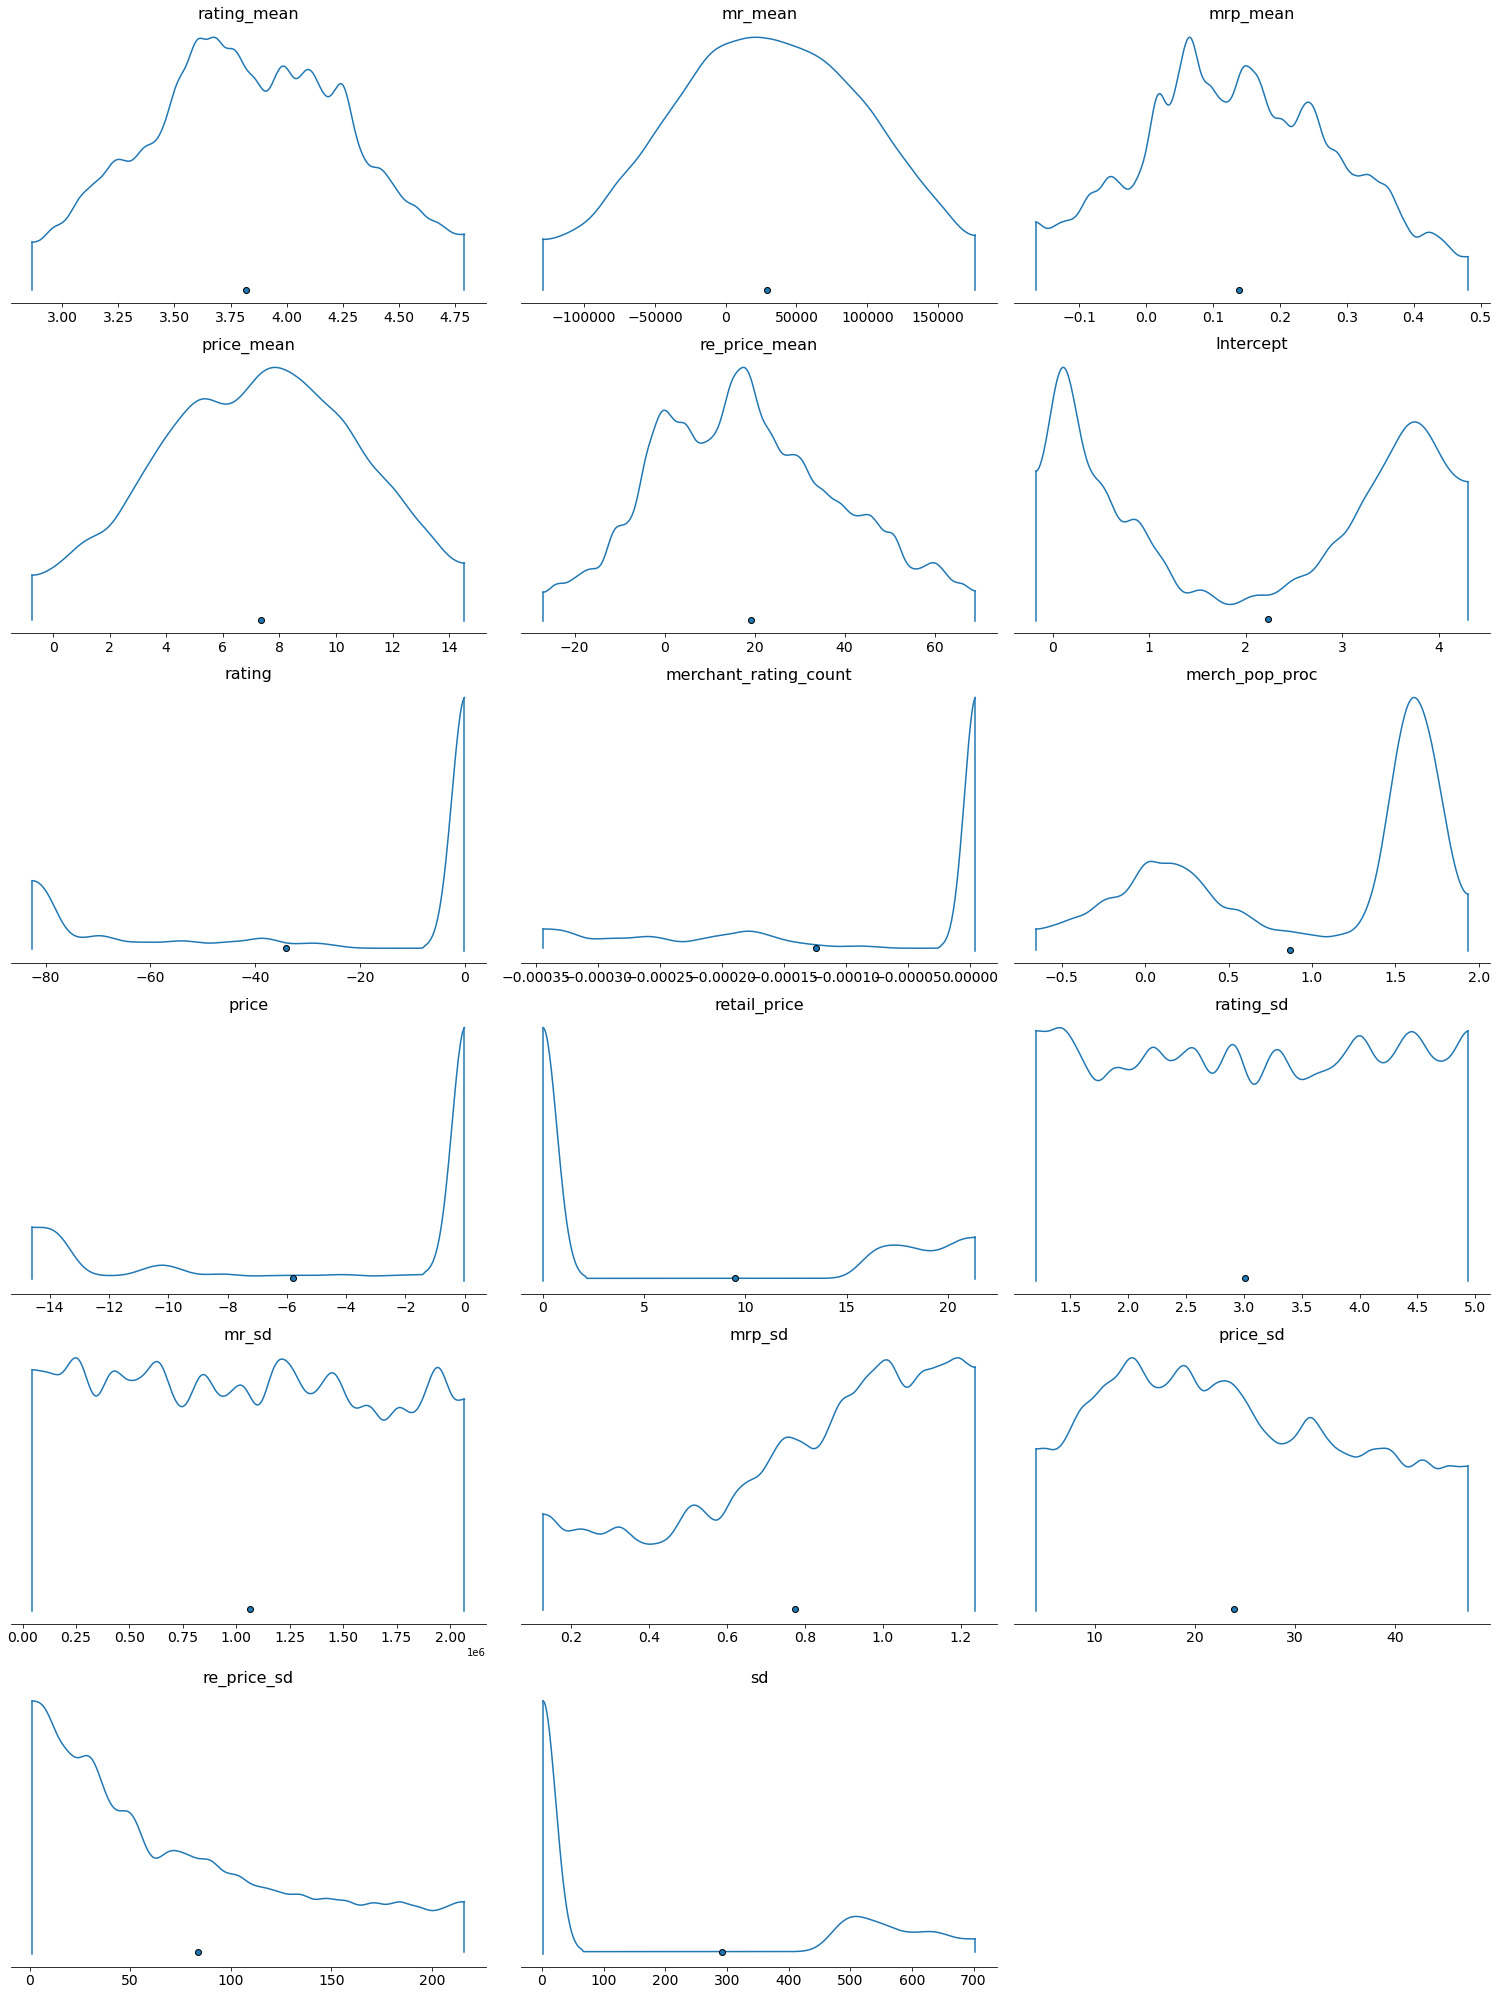

In [37]:
pm.densityplot(complex_h_trace);

In [38]:
# print("\n====================== LR_without_GLM =====================================")
# for variable in trace.varnames:
#     print('Variable: {:15} Mean weight in model: {:.4f}'.format(variable, 
#                                                                 np.mean(trace[variable])))
# print("\n====================== GLM_LR =====================================")
# for variable in normal_lr_trace.varnames:
#     print('Variable: {:15} Mean weight in model: {:.4f}'.format(variable, 
#                                                                 np.mean(normal_lr_trace[variable])))
# print("\n====================== GLM_LR_STD =====================================")    
# for variable in st_normal_lr_trace.varnames:
#     print('Variable: {:15} Mean weight in model: {:.4f}'.format(variable, 
#                                                                 np.mean(st_normal_lr_trace[variable])))
# print("\n====================== GLM__Simple_H =====================================")
# for variable in simple_h_trace.varnames:
#     print('Variable: {:15} Mean weight in model: {:.4f}'.format(variable, 
#                                                                 np.mean(simple_h_trace[variable])))
# print("\n====================== GLM__Baseline_H =====================================")
# for variable in basline_h_trace.varnames:
#     print('Variable: {:15} Mean weight in model: {:.4f}'.format(variable, 
#                                                                 np.mean(basline_h_trace[variable])))
    
# print("\n====================== GLM__Complex_H =====================================")
# for variable in complex_h_trace.varnames:
#     print('Variable: {:15} Mean weight in model: {:.4f}'.format(variable, 
#                                                                 np.mean(complex_h_trace[variable])))

In [39]:
# model_formula = 'y ~ '
# print("\n====================== LR_without_GLM =====================================")
# for variable in trace.varnames:
#     model_formula += '(%0.4f * %s) + ' % (np.mean(trace[variable]), variable)

# print(' '.join(model_formula.split(' ')[:-2]))

# print("\n====================== GLM_LR =====================================")
# model_formula = 'y ~ '
# for variable in normal_lr_trace.varnames:
#     model_formula += '(%0.4f * %s) + ' % (np.mean(normal_lr_trace[variable]), variable)
# print(' '.join(model_formula.split(' ')[:-2]))

# print("\n====================== GLM_LR_STD =====================================")
# model_formula = 'y ~ '
# for variable in st_normal_lr_trace.varnames:
#     model_formula += '(%0.4f * %s) + ' % (np.mean(st_normal_lr_trace[variable]), variable)
# print(' '.join(model_formula.split(' ')[:-2]))

# print("\n====================== GLM__Simple_H =====================================")
# model_formula = 'y ~ '
# for variable in simple_h_trace.varnames:
#     model_formula += '(%0.4f * %s) + ' % (np.mean(simple_h_trace[variable]), variable)

# print(' '.join(model_formula.split(' ')[:-2]))

# print("\n====================== GLM__Baseline_H =====================================")
# model_formula = 'y ~ '
# for variable in basline_h_trace.varnames:
#     model_formula += '(%0.4f * %s) + ' % (np.mean(basline_h_trace[variable]), variable)

# print(' '.join(model_formula.split(' ')[:-2]))

# print("\n====================== GLM__Complex_H =====================================")
# model_formula = 'y ~ '
# for variable in complex_h_trace.varnames:
#     model_formula += '(%0.4f * %s) + ' % (np.mean(complex_h_trace[variable]), variable)

# print(' '.join(model_formula.split(' ')[:-2]))


In [40]:
from sklearn.metrics import mean_squared_error
def evaluate_trace(trace, X_train, X_test, y_train, y_test, model_results=None):
    
    # Dictionary of all sampled values for each parameter
    var_dict = {}
    for variable in trace.varnames:
        var_dict[variable] = trace[variable]
        
    # Results into a dataframe
    var_weights = pd.DataFrame(var_dict)
    
    # Means for all the weights
    var_means = var_weights.mean(axis=0)
    
    # Create an intercept column
    X_test['Intercept'] = 1
    
    # Align names of the test observations and means
    names = X_test.columns
    X_test = X_test.loc[:, names]
    var_means = var_means[names]
    
    # Calculate estimate for each test observation using the average weights
    results = pd.DataFrame(index = X_test.index, columns = ['estimate'])

    for row in X_test.iterrows():
        results.loc[row[0], 'estimate'] = np.dot(np.array(var_means), np.array(row[1]))
    
    # Metrics 
    actual = np.array(y_test)
    errors = results['estimate'] - actual
    rmse = np.sqrt(mean_squared_error(results['estimate'], actual))
    mape = np.median(abs(errors) / actual)
    
    print('Model RMSE: {:.4f}\nModel MAPE: {:.4f}'.format(rmse, mape))

    # Plot the observations and predictions
    # figsize(10, 10)
    # plt.scatter(results.index, actual, label = 'Observed', color = 'blue')
    # plt.scatter(results.index, results['estimate'], label = 'Estimate', color = 'red')
    # plt.legend(prop={'size': 14}); plt.xlabel('Index'); plt.ylabel('Grade');
    # plt.title('Observed and Estimated Values')
    # plt.show()
    
    return results

In [41]:
# print("\n====================== LR_without_GLM =====================================")
# results = evaluate_trace(trace, X_train_math, X_test_math, y_train_math, y_test_math, None)

print("\n====================== GLM_LR =====================================")
results = evaluate_trace(normal_lr_trace, X_train_math, X_test_math, y_train_math, y_test_math, None)

print("\n====================== GLM_LR_STD =====================================")
results = evaluate_trace(st_normal_lr_trace, X_train_math, X_test_math, y_train_math, y_test_math, None)


print("\n====================== GLM__Simple_H =====================================")
results = evaluate_trace(simple_h_trace, X_train_math, X_test_math, y_train_math, y_test_math, None)


print("\n====================== GLM__Complex_H =====================================")
results = evaluate_trace(complex_h_trace, X_train_math, X_test_math, y_train_math, y_test_math, None)


====================== GLM_LR =====================================
Model RMSE: 0.5796
Model MAPE: -0.4377

====================== GLM_LR_STD =====================================
Model RMSE: 0.7552
Model MAPE: -0.0463

====================== GLM__Simple_H =====================================
Model RMSE: 0.5719
Model MAPE: -0.3888

====================== GLM__Complex_H =====================================
Model RMSE: 292.1484
Model MAPE: -173.6580


In [42]:
from sklearn.metrics import mean_squared_error
def evaluate_trace_base(trace, X_train, X_test, y_train, y_test, model_results=None):
    
    # Dictionary of all sampled values for each parameter
    var_dict = {}
    for variable in trace.varnames:
        print(trace[variable].shape)
        var_dict[variable] = trace[variable]
    # print(var_dict)
    # Results into a dataframe
    var_weights = pd.DataFrame(var_dict)
    
    # Means for all the weights
    var_means = var_weights.mean(axis=0)
    
    # Create an intercept column
    X_test['Intercept'] = 1
    
    # Align names of the test observations and means
    names = X_test.columns.drop('price').drop('retail_price')
    print("names: ",names)
    X_test = X_test.loc[:, names]
    var_means = var_means[names]
    
    # Calculate estimate for each test observation using the average weights
    results = pd.DataFrame(index = X_test.index, columns = ['estimate'])

    for row in X_test.iterrows():
        results.loc[row[0], 'estimate'] = np.dot(np.array(var_means), np.array(row[1]))
    # print("results: ",results)
    # Metrics 
    actual = np.array(y_test)
    errors = results['estimate'] - actual
    rmse = np.sqrt(mean_squared_error(results['estimate'], actual))
    mape = np.median(abs(errors) / actual)
    
    print('Model RMSE: {:.4f}\nModel MAPE: {:.4f}'.format(rmse, mape))

    # Plot the observations and predictions
    # figsize(10, 10)
    # plt.scatter(results.index, actual, label = 'Observed', color = 'blue')
    # plt.scatter(results.index, results['estimate'], label = 'Estimate', color = 'red')
    # plt.legend(prop={'size': 14}); plt.xlabel('Index'); plt.ylabel('Grade');
    # plt.title('Observed and Estimated Values')
    # plt.show()
    
    
    return results
print("\n====================== GLM__Baseline_H =====================================")
results = evaluate_trace_base(basline_h_trace, X_train_math, X_test_math, y_train_math, y_test_math, None)


====================== GLM__Baseline_H =====================================
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
(10000,)
names:  Index(['rating', 'merchant_rating_count', 'merch_pop_proc', 'Intercept'], dtype='object')
Model RMSE: 0.5878
Model MAPE: -0.4758


In [ ]:
# pm.model_to_graphviz(first_model)

In [ ]:
# pm.model_to_graphviz(normal_lr_model)

In [ ]:
# pm.model_to_graphviz(st_normal_lr_model)

In [ ]:
# pm.model_to_graphviz(basline_h)

In [ ]:
# pm.model_to_graphviz(simple_h)

In [ ]:
# pm.model_to_graphviz(complex_h)

In [ ]:
# !pip install arviz

In [ ]:
# import arviz as az
# # first_mdel_loo = az.waic(trace, first_model)
# # first_waic = az.waic( trace,first_model)
# nor_waic = az.waic( normal_lr_trace,normal_lr_model)
# st_nor_waic = az.waic(st_normal_lr_trace,normal_lr_model)

# base_waic = az.waic( basline_h_trace,basline_h)
# simple_waic = az.waic(simple_h_trace,simple_h)
# complex_waic = az.waic(complex_h_trace,complex_h)


# df_comp_loo = az.compare({"LR_xGLM": normal_lr_trace, "st_LR": st_normal_lr_trace,"LR": normal_lr_trace, 
#                           "base_h": basline_h_trace, "simple_h": simple_h_trace,"complex_h": complex_h_trace})
# df_comp_loo


In [ ]:
# az.plot_compare(df_comp_loo, insample_dev=False);

In [ ]:
# df_comp_loo = pm.compare({"LR_xGLM": normal_lr_trace, "st_LR": st_normal_lr_trace,"LR": normal_lr_trace, 
#                           "base_h": basline_h_trace, "simple_h": simple_h_trace,"complex_h": complex_h_trace}, ic="WAIC")
# df_comp_loo.index = pd.MultiIndex.from_tuples([tuple(k.split(",")) for k, v in df_comp_loo.iterrows()])

# df_comp_loo

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [beta_retail_price]
>Metropolis: [beta_price]
>Metropolis: [beta_merch_pop_proc]
>Metropolis: [beta_merchant_rating_count]
>Metropolis: [beta_rating]
>Metropolis: [beta_0]
Sampling chain 1, 0 divergences: 100%|██████████| 6000/6000 [00:07<00:00, 750.86it/s]
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb1223307f0>,
      dtype=object)

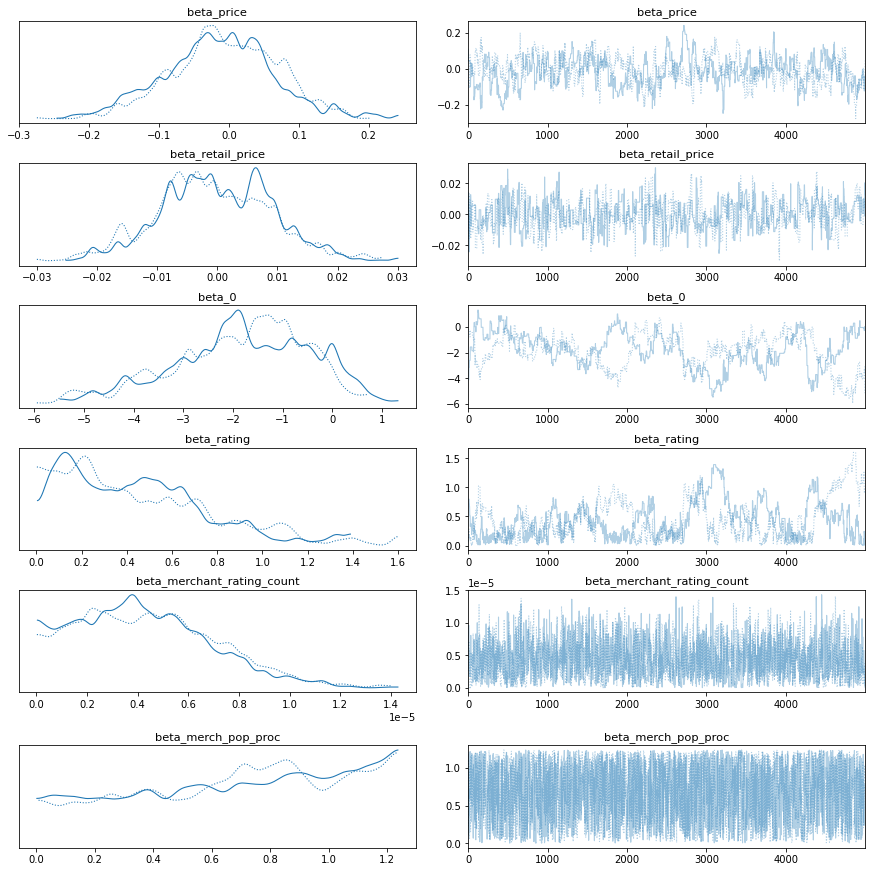

In [118]:
#without_GLM
with pm.Model() as first_model_fix:
    #priors on parameters
    beta_0=pm.Uniform('beta_0', lower=-10, upper= 10)
    
    beta_rating=pm.Uniform('beta_rating',0, 5)

    beta_merchant_rating_count  = pm.Uniform('beta_merchant_rating_count',0, 5)
    beta_merch_pop_proc=pm.Uniform('beta_merch_pop_proc', df1['merch_pop_proc'].min(), df1['merch_pop_proc'].max())
    
    beta_price=pm.Normal('beta_price',df1['price'].mean(), df1['price'].std())
    beta_retail_price=pm.Normal('beta_retail_price', df1['retail_price'].mean(), df1['retail_price'].std())

    rating = pm.Data("rating", X_train_math['rating'])
    
    merchant_rating_count = pm.Data("merchant_rating_count", X_train_math['merchant_rating_count'])
    merch_pop_proc = pm.Data("merch_pop_proc", X_train_math['merch_pop_proc'])
    
    price = pm.Data("price", X_train_math['price'])
    retail_price = pm.Data("retail_price", X_train_math['retail_price'])
        
    tmp =beta_0+pm.math.dot(beta_rating,rating)+pm.math.dot(beta_merchant_rating_count,merchant_rating_count)+pm.math.dot(beta_merch_pop_proc,merch_pop_proc)+pm.math.dot(beta_price,price)+pm.math.dot(beta_retail_price,retail_price)
                              #  pm.math.dot(beta_retail_price,df['retail_price']))
    # tmp = pm.Deterministic('p',beta_0+beta_rating*rating+
    #                            beta_merchant_rating_count*merchant_rating_count+
    #                            beta_merch_pop_proc*merch_pop_proc+
    #                            beta_price*price+
    #                            beta_retail_price*retail_price)
    # print(tmp.shape)
    # theta = tt.nnet.softmax(tmp)
    # print(theta.shape)
    # yl = pm.Categorical('yl', p=theta, observed=y_train_math)
    observed=pm.Normal("y", mu=tmp,sd = 10, observed=y_train_math)
    trace_fix=pm.sample(init='adapt_diag',draws=NDRAWS, tune = 1000,step = pm.Metropolis())
pm.traceplot(trace_fix)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [beta_retail_price]
>Metropolis: [beta_price]
>Metropolis: [beta_merch_pop_proc]
>Metropolis: [beta_merchant_rating_count]
>Metropolis: [beta_rating]
>Metropolis: [beta_0]
Sampling chain 1, 0 divergences: 100%|██████████| 6000/6000 [00:08<00:00, 697.56it/s]
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb123389a58>,
      dtype=object)

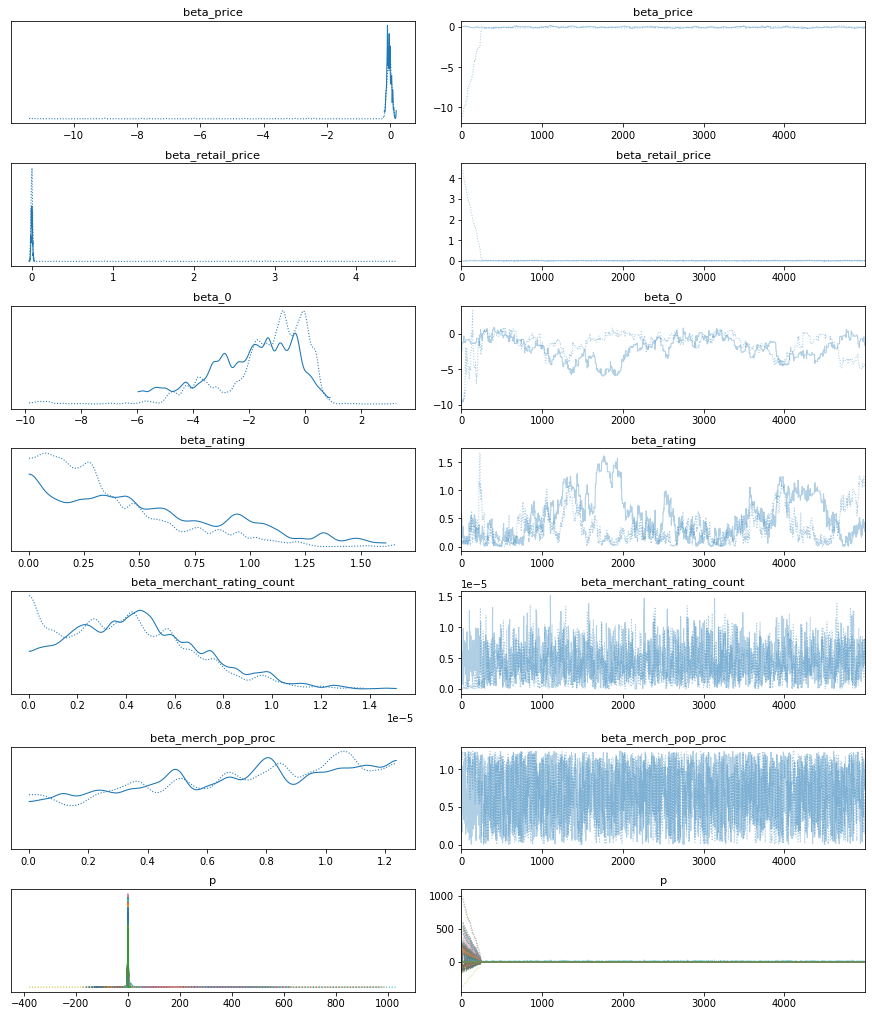

In [130]:
#without_GLM
with pm.Model() as first_model:
    #priors on parameters
    beta_0=pm.Uniform('beta_0', lower=-10, upper= 10)
    
    beta_rating=pm.Uniform('beta_rating',0, 5)

    beta_merchant_rating_count  = pm.Uniform('beta_merchant_rating_count',0, 5)
    beta_merch_pop_proc=pm.Uniform('beta_merch_pop_proc', df1['merch_pop_proc'].min(), df1['merch_pop_proc'].max())
    
    beta_price=pm.Normal('beta_price',df1['price'].mean(), df1['price'].std())
    beta_retail_price=pm.Normal('beta_retail_price', df1['retail_price'].mean(), df1['retail_price'].std())

    rating = pm.Data("rating", X_train_math['rating'])
    
    merchant_rating_count = pm.Data("merchant_rating_count", X_train_math['merchant_rating_count'])
    merch_pop_proc = pm.Data("merch_pop_proc", X_train_math['merch_pop_proc'])
    
    price = pm.Data("price", X_train_math['price'])
    retail_price = pm.Data("retail_price", X_train_math['retail_price'])
        
    tmp = pm.Deterministic('p',beta_0+pm.math.dot(beta_rating,rating)+
                               pm.math.dot(beta_merchant_rating_count,merchant_rating_count)+
                               pm.math.dot(beta_merch_pop_proc,merch_pop_proc)+
                               pm.math.dot(beta_price,price)+
                               pm.math.dot(beta_retail_price,retail_price))
                              #  pm.math.dot(beta_retail_price,df['retail_price']))
    # tmp = pm.Deterministic('p',beta_0+beta_rating*rating+
    #                            beta_merchant_rating_count*merchant_rating_count+
    #                            beta_merch_pop_proc*merch_pop_proc+
    #                            beta_price*price+
    #                            beta_retail_price*retail_price)
    # print(tmp.shape)
    # theta = tt.nnet.softmax(tmp)
    # print(theta.shape)
    # yl = pm.Categorical('yl', p=theta, observed=y_train_math)
    observed=pm.Normal("y", mu=tmp,sd = 10, observed=y_train_math)
    trace=pm.sample(init='adapt_diag',draws=NDRAWS, tune = 1000,step = pm.Metropolis())
pm.traceplot(trace)

In [120]:
# pm.densityplot(trace);

/usr/local/lib/python3.6/dist-packages/arviz/plots/plot_utils.py:483: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (1479) in plot_posterior, generating only 40 plots
  UserWarning,
/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:01<00:00, 745.72it/s]
arviz.data.io_pymc3 - WARNING - posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


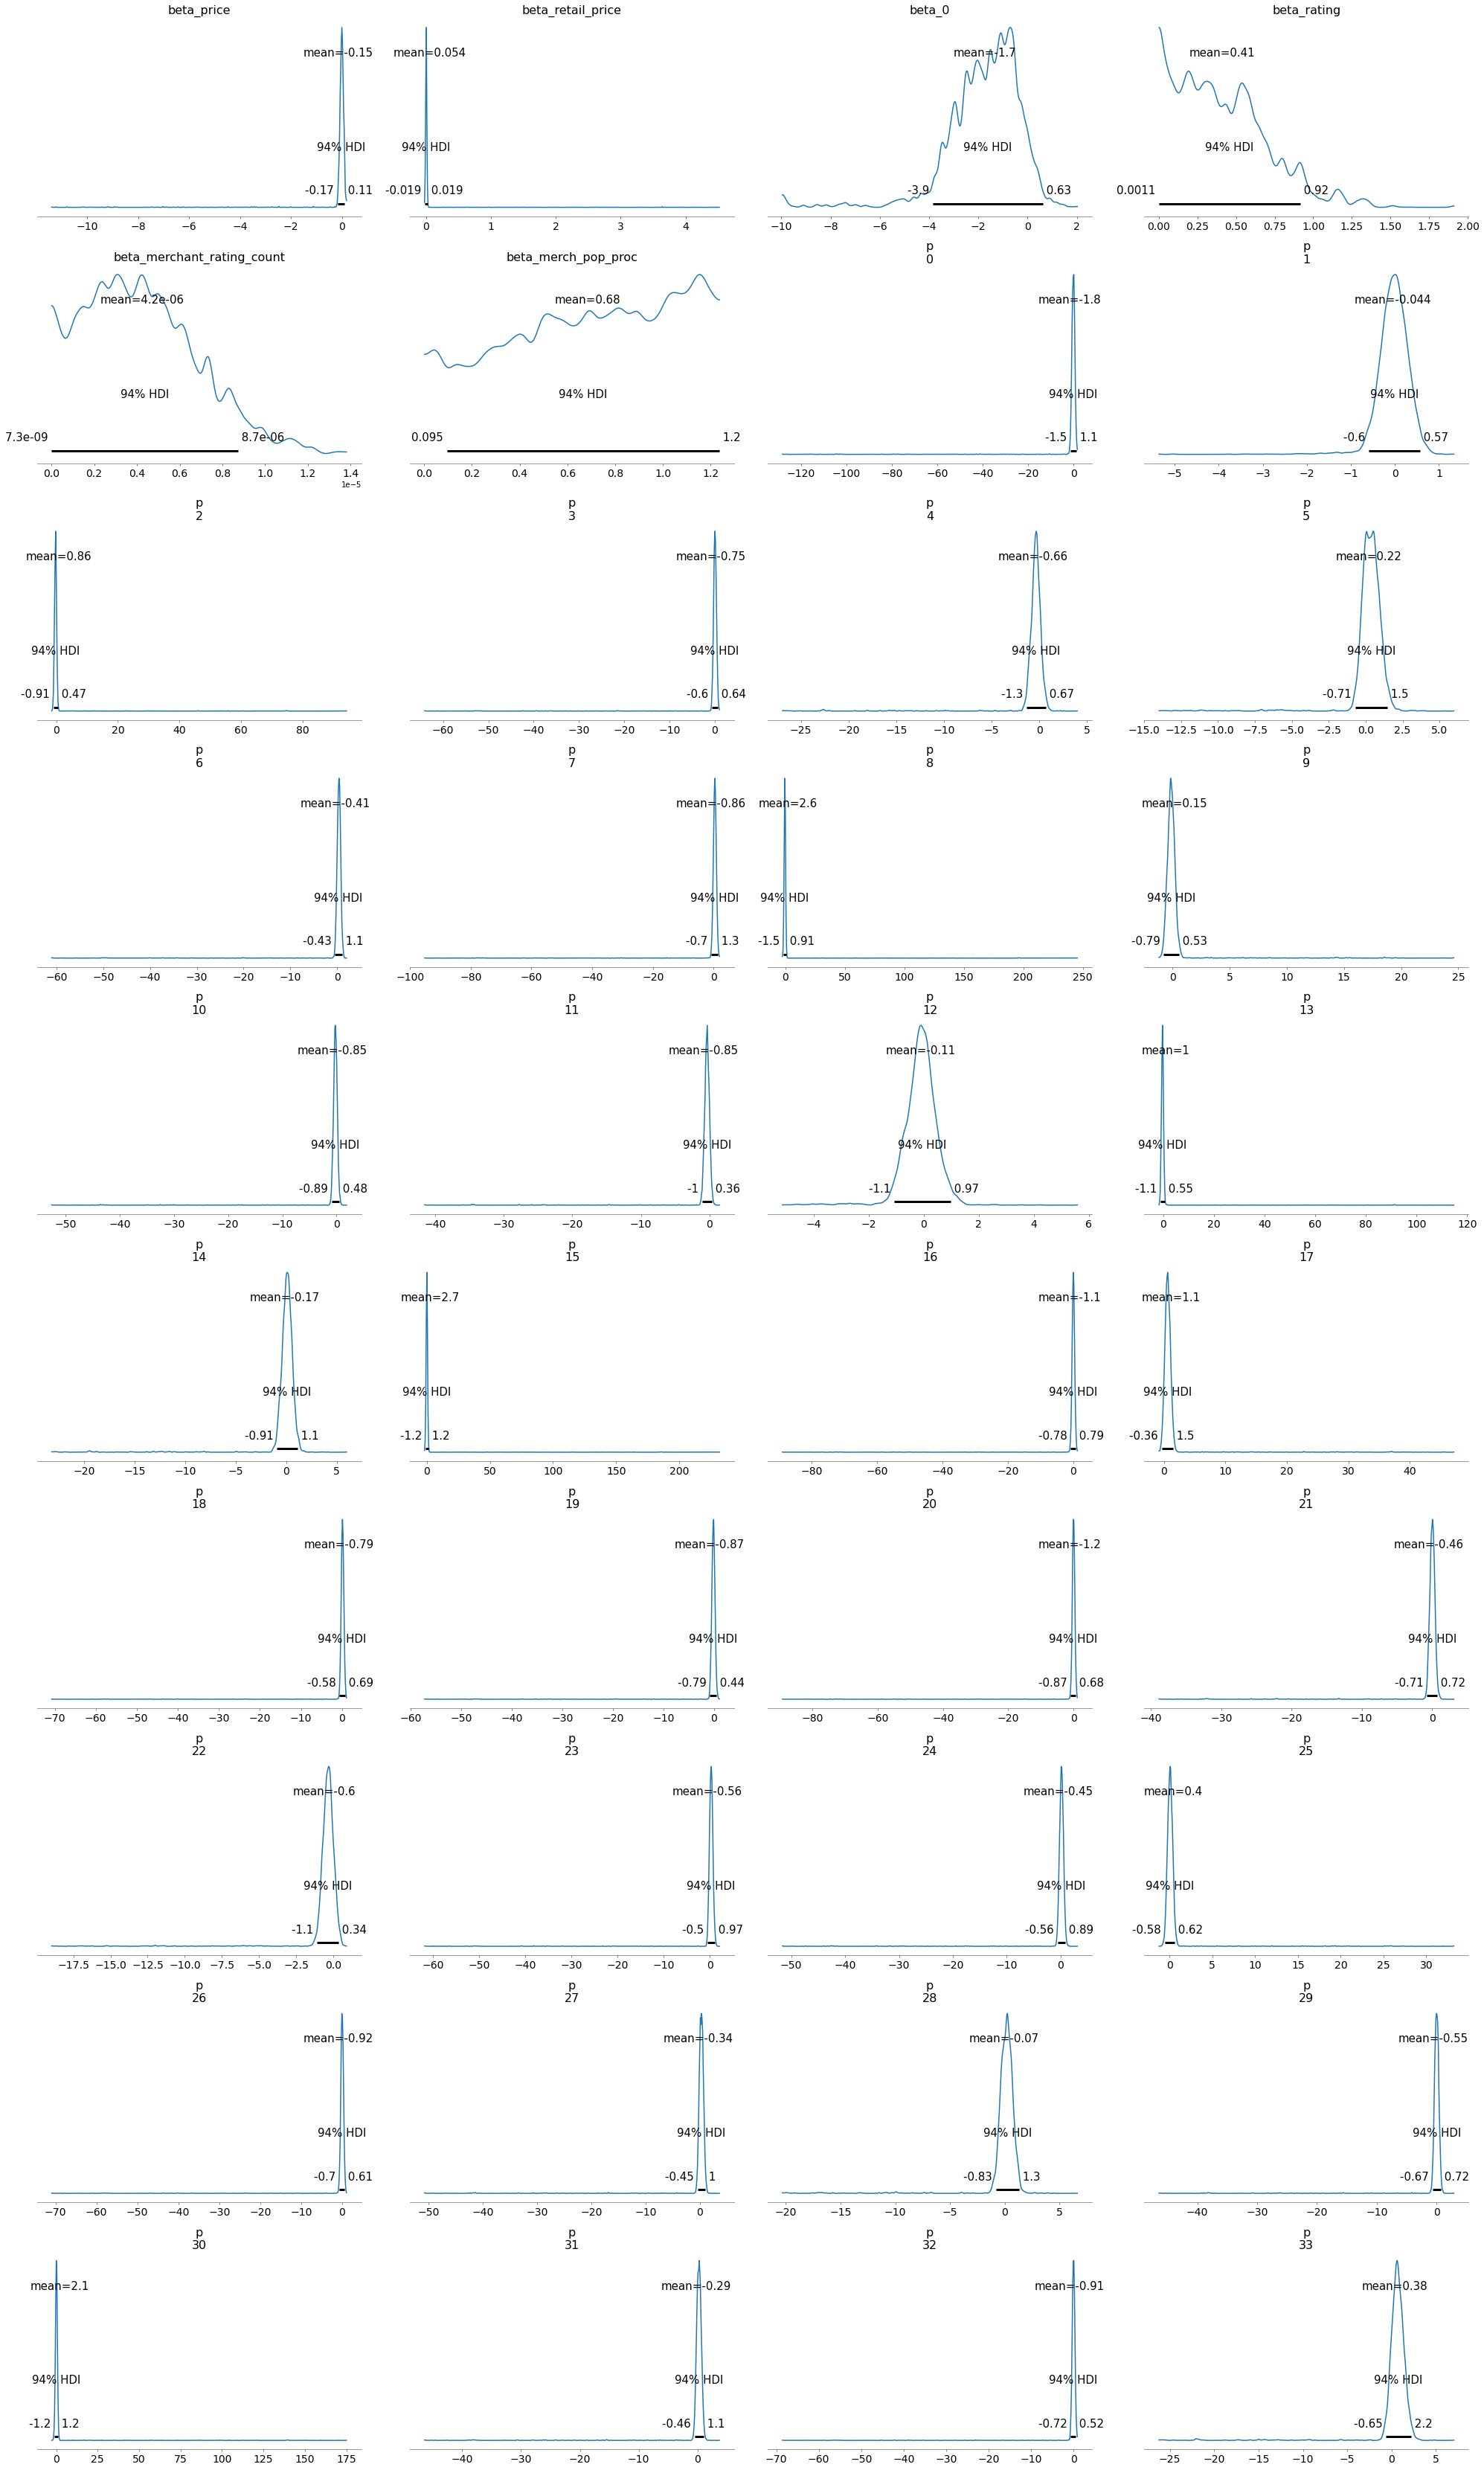

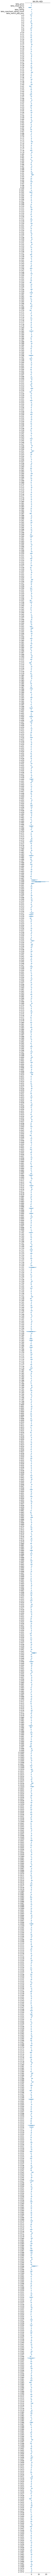

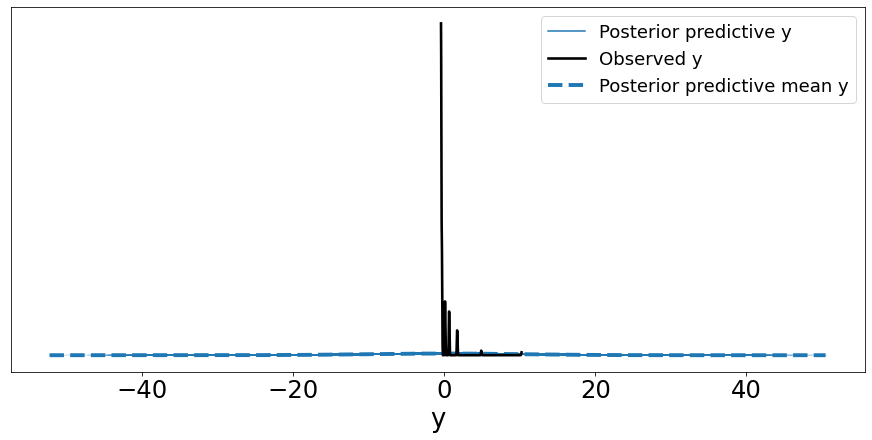

In [121]:
import arviz as az

az.plot_posterior(trace)

axes = az.plot_forest(trace)

# X_train_math.columns
y_pred_g = pm.sample_posterior_predictive(trace,1000, first_model)
data_ppc = az.from_pymc3(trace=trace, posterior_predictive=y_pred_g)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)
# ax[0].legend(fontsize=15)

/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:01<00:00, 820.06it/s]
arviz.data.io_pymc3 - WARNING - posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


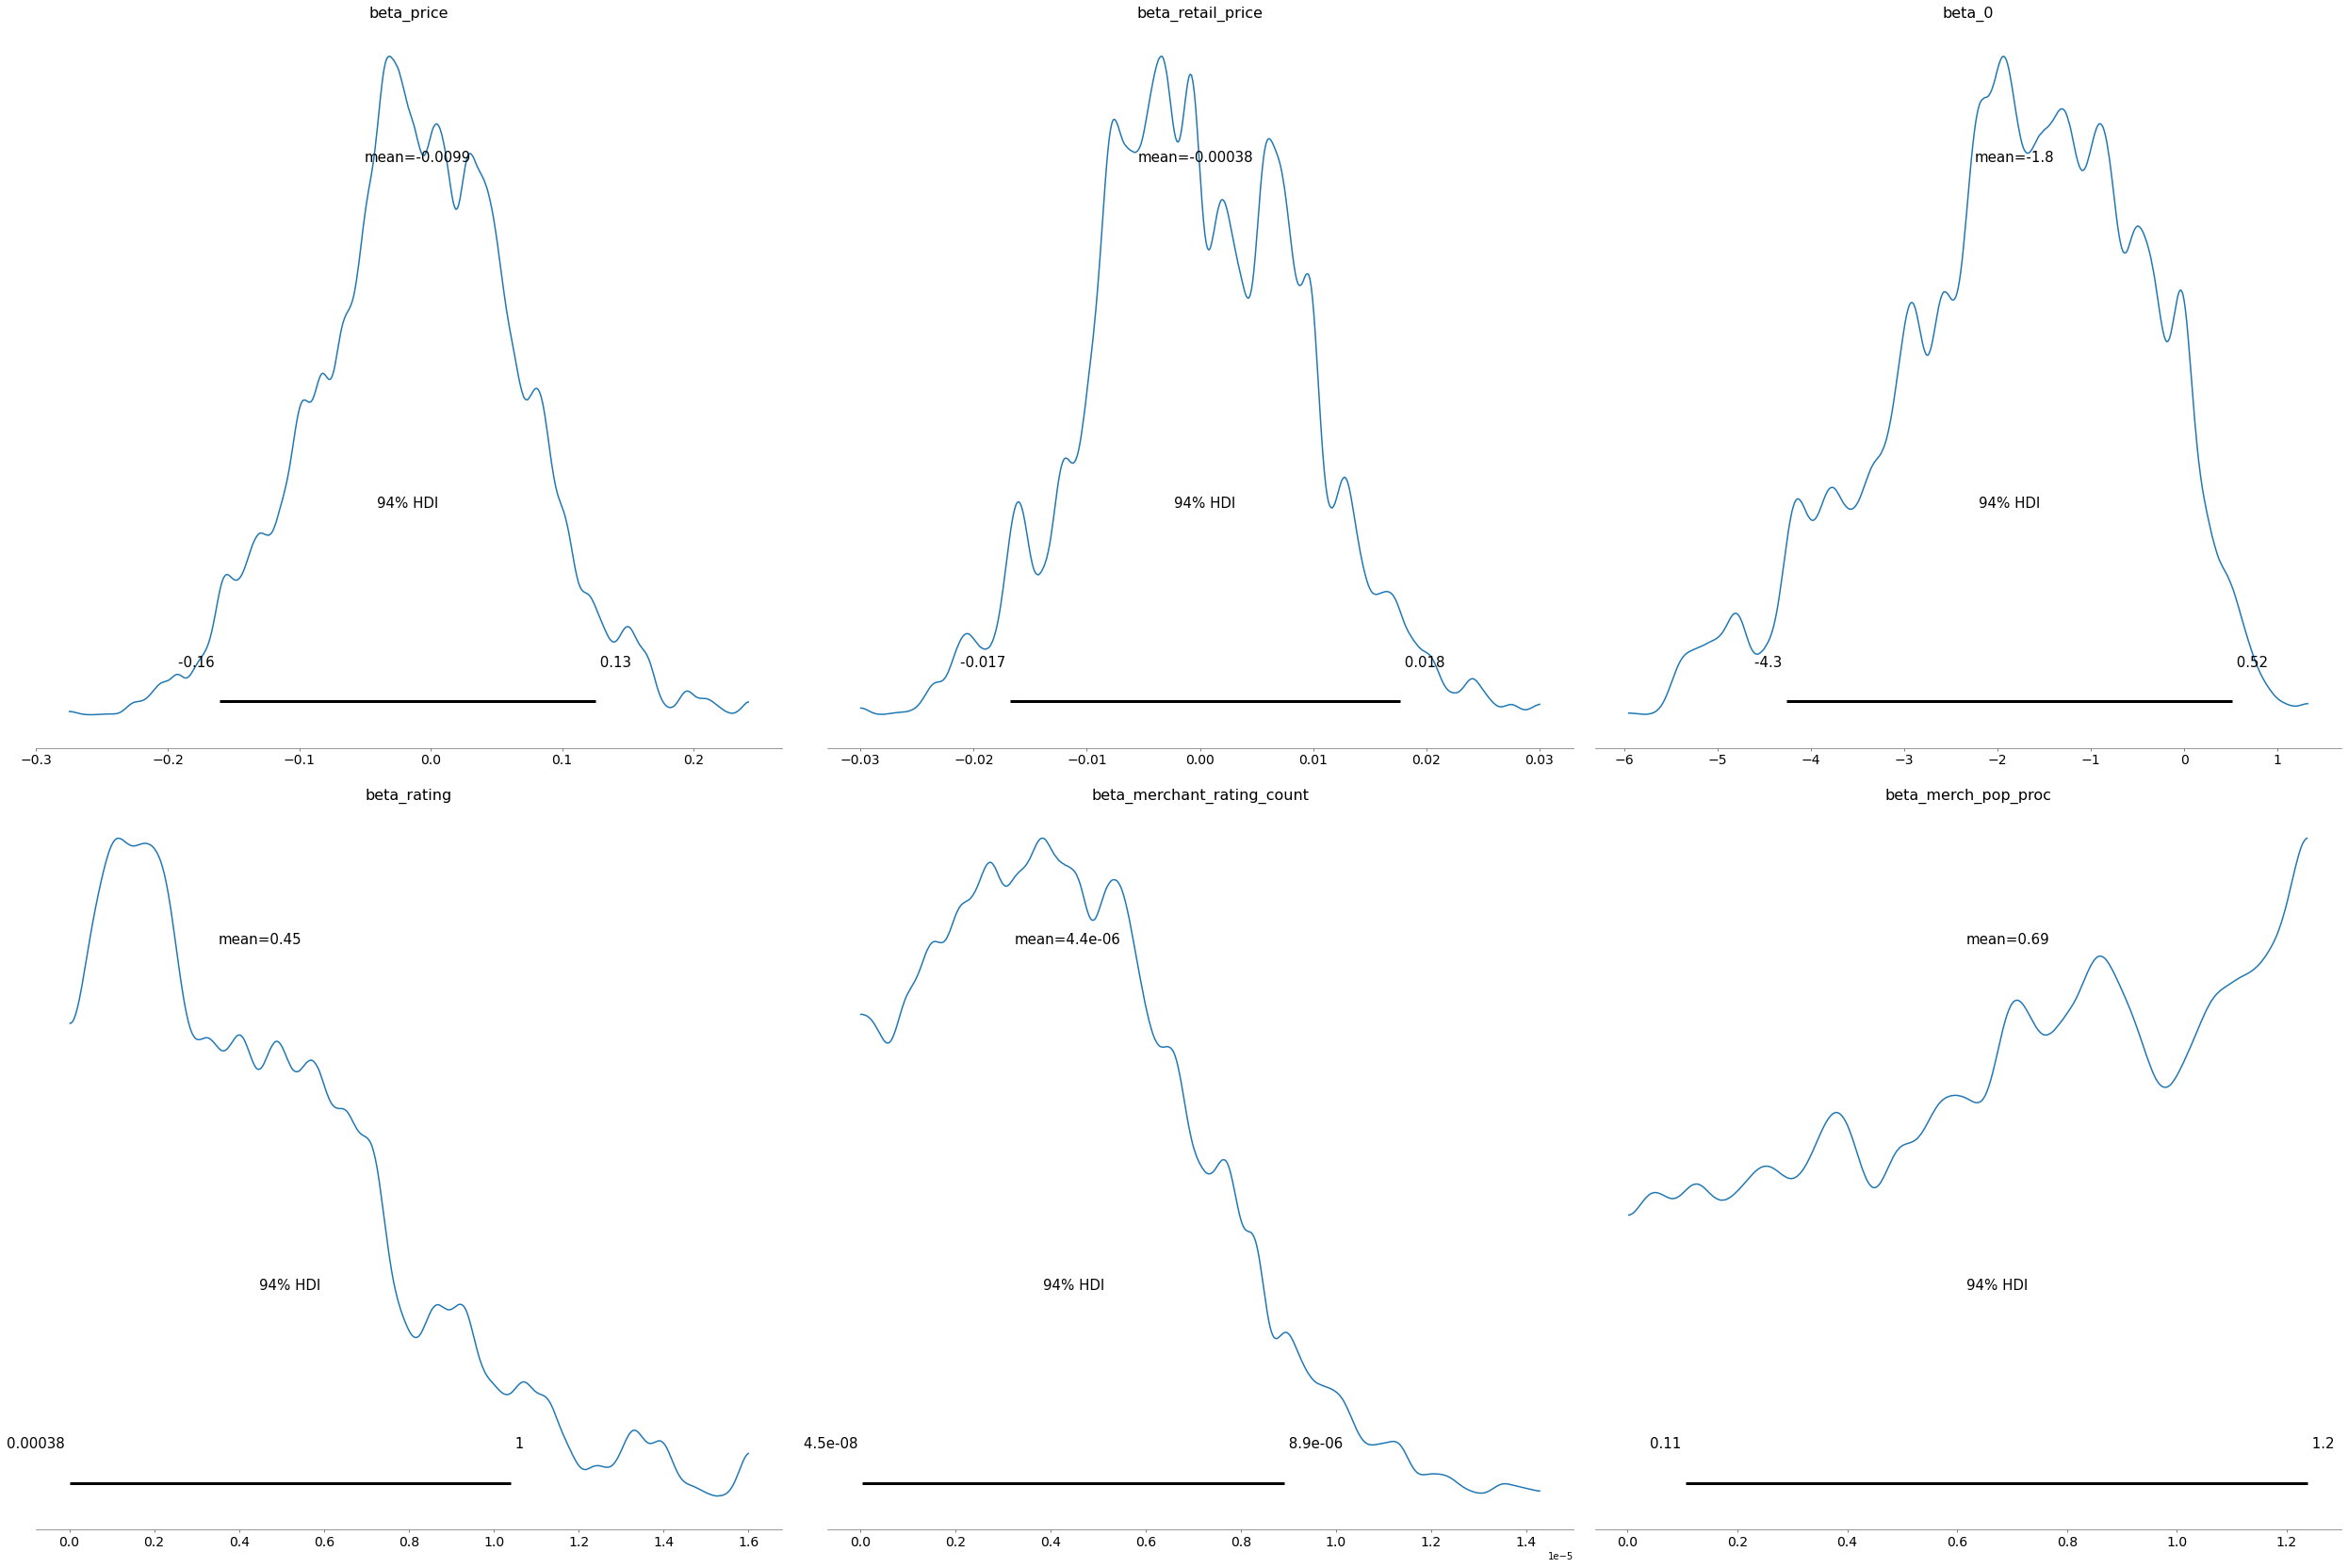

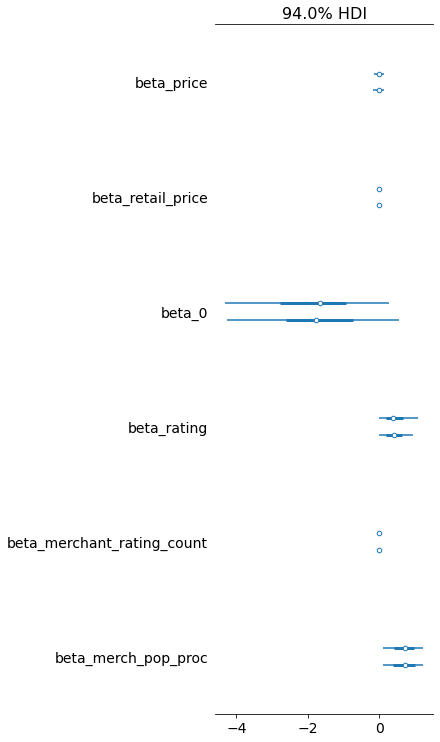

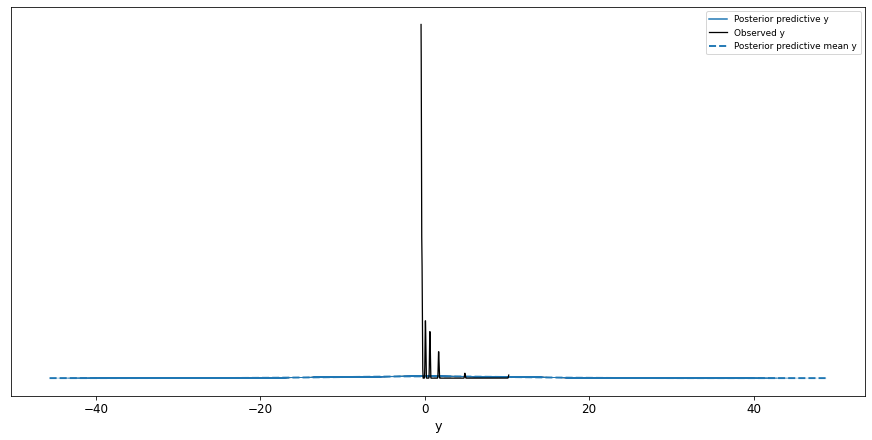

In [126]:
import arviz as az

az.plot_posterior(trace_fix)

axes = az.plot_forest(trace_fix)

# X_train_math.columns
y_pred_g = pm.sample_posterior_predictive(trace_fix,1000, first_model_fix)
data_ppc = az.from_pymc3(trace=trace_fix, posterior_predictive=y_pred_g)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)
# ax[0].legend(fontsize=15)

In [ ]:
with model_sf:
    pm.set_data({"X": x_s})
    post_checks = pm.sample_posterior_predictive(trace_sf, random_seed=RANDOM_SEED)

In [127]:
from sklearn.metrics import mean_squared_error
def evaluate(trace, X_train, X_test, y_train, y_test, model_results=None):
    print(X_test.shape)
    with first_model:
        # update values of predictors:
        '''
        rating = pm.Data("rating", X_train_math['rating'])
    
        merchant_rating_count = pm.Data("merchant_rating_count", X_train_math['merchant_rating_count'])
        merch_pop_proc = pm.Data("merch_pop_proc", X_train_math['merch_pop_proc'])
    
        price = pm.Data("price", X_train_math['price'])
        retail_price = pm.Data("retail_price", X_train_math['retail_price'])
    
        '''
        pm.set_data({'rating':X_test['rating'],
                     'merchant_rating_count':X_test['merchant_rating_count'],
                     'merch_pop_proc':X_test['merch_pop_proc'],
                     'price':X_test['price'],
                     'retail_price':X_test['retail_price'],
                     })
        # use the updated values and predict outcomes and probabilities:
        posterior_predictive = pm.sample_posterior_predictive(trace,var_names=['y'])
        model_preds = posterior_predictive["y"]
    
    print("model_preds:",posterior_predictive['y'].shape)
    print("model_preds:",posterior_predictive['y'].mean(0))
    # Metrics 
    actual = np.array(y_test)
    # print("nor_y_predict:",nor_y_predict)
    print("actual: ",actual.shape)
    # print(actual)
    print()
    errors = posterior_predictive['y'].mean(0) - actual
    rmse = np.sqrt(mean_squared_error(posterior_predictive['y'].mean(0), actual))
    mape = np.median(abs(errors) / actual)

    
    print('Model RMSE: {:.4f}\nModel MAPE: {:.4f}'.format(rmse, mape))
print("\n====================== LR Without GLM =====================================")
results = evaluate(trace, X_train_math, X_test_math, y_train_math, y_test_math, None)

  0%|          | 42/10000 [00:00<00:24, 410.96it/s]


====================== LR Without GLM =====================================
(100, 6)


100%|██████████| 10000/10000 [00:26<00:00, 384.25it/s]

model_preds: (10000, 100)
model_preds: [-0.13314538  0.21003915  2.99726443 -0.61033787 -1.11159029 -0.77027735
  0.26741084 -1.85080771  2.60582621 -1.0656438   0.08462927 -0.46073874
  1.37692551 -0.43937949  0.5714066  -1.25254874 -0.75813047  4.74406948
  7.11082498 -1.09625032 -0.85664086  2.13629645 -0.99129869 -0.64357271
  0.25127357  1.62186011  3.28724803 -0.54155901 -0.98854995 -0.58481038
 -1.44257237 -0.19511491 -0.01915237 -0.7462781  -0.0999582  -1.07583943
 -0.32830806  0.22795153  2.88083033 -0.68341708 -1.65112022 -0.44958464
  1.69893786 -1.63808811 -1.05837896 -0.96804518 -1.01252582 -0.88905485
 -0.75537101  0.80876701 -1.03363776 -0.50098468  0.58779409 -1.03384085
  2.12535644 -0.67486905 -0.89004264 -1.60148969 -2.69528711 -0.20056265
 -1.55502799  0.67766704  0.56839105 -1.06944922 -1.00748424 -1.15768275
 -1.20461126 -0.34360768  3.154593   -0.96967561 -0.61892094 -0.87214135
 -0.7827549  -1.24435303 -0.44139295  3.17643804  2.0846005  -0.61231056
 -1.11046346

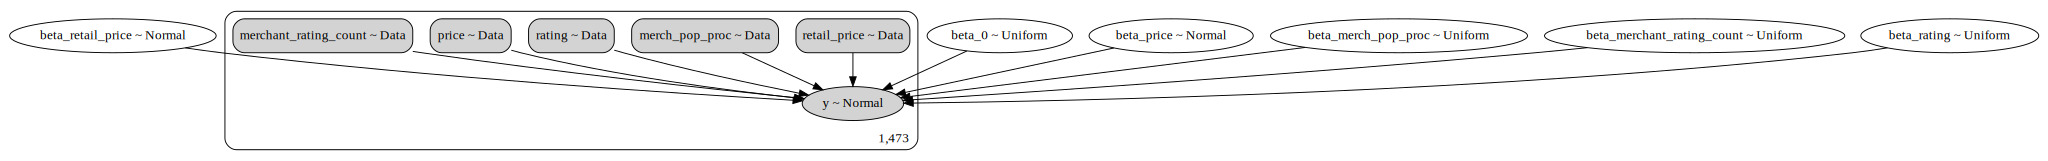

In [134]:
pm.model_to_graphviz(first_model_fix)

In [136]:
import arviz as az
# first_mdel_loo = az.waic(trace, first_model)
# first_waic = az.waic( trace,first_model)
# fix_first_waic = az.waic( trace_fix,first_model_fix)
# nor_waic = az.waic( normal_lr_trace,normal_lr_model)
# st_nor_waic = az.waic(st_normal_lr_trace,normal_lr_model)

# base_waic = az.waic( basline_h_trace,basline_h)
# simple_waic = az.waic(simple_h_trace,simple_h)
# complex_waic = az.waic(complex_h_trace,complex_h)


df_comp_loo = az.compare({"LR_xGLM":trace,"LR_xGLM_fix":trace_fix,"LR": normal_lr_trace, "st_LR": st_normal_lr_trace, 
                          "base_h": basline_h_trace, "simple_h": simple_h_trace,"complex_h": complex_h_trace})
df_comp_loo


/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:150: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
  "\nThe scale is now log by default. Use 'scale' argument or "
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:684: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:684: UserWarning: Estimated shape parameter of Pareto distribution is grea

rank      loo     p_loo  ...      dse warning loo_scale
st_LR          0 -611.239   13.7141  ...        0   False       log
LR             1 -2026.19   59.0992  ...  139.806    True       log
simple_h       2 -2028.89   58.7189  ...  139.746    True       log
base_h         3 -2032.13   56.4935  ...  139.275    True       log
LR_xGLM_fix    4 -4754.82  0.538274  ...  90.0011   False       log
complex_h      5 -9538.06   7197.25  ...  146.567    True       log
LR_xGLM        6 -78421.4   73638.5  ...  10484.8    True       log

[7 rows x 9 columns]

In [139]:

df_comp_loo = pm.compare({"LR_xGLM":trace,"LR_xGLM_fix":trace_fix,"LR": normal_lr_trace,  "st_LR": st_normal_lr_trace,
                          "base_h": basline_h_trace, "simple_h": simple_h_trace,"complex_h": complex_h_trace}, ic="WAIC")
df_comp_loo.index = pd.MultiIndex.from_tuples([tuple(k.split(",")) for k, v in df_comp_loo.iterrows()])

df_comp_loo

/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:150: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
  "\nThe scale is now log by default. Use 'scale' argument or "
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:1427: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:1427: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the pos

rank     waic    p_waic  ...      dse warning waic_scale
st_LR          0 -610.942   13.4173  ...        0    True        log
LR             1 -2033.78   66.6903  ...  142.562    True        log
base_h         2 -2037.79   62.1593  ...  141.291    True        log
simple_h       3 -2038.21   68.0305  ...  143.173    True        log
LR_xGLM_fix    4 -4754.75  0.470946  ...  89.9912   False        log
complex_h      5 -18058.3   15717.5  ...  1116.33    True        log
LR_xGLM        6  -769232    764450  ...   241159    True        log

[7 rows x 9 columns]